In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tqdm import tqdm

# Constants
CITYSCAPES_DIR = os.path.abspath("../data")
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
LIMIT_IMAGES = 1000
LABEL_ID = 7
BATCH_SIZE = 32
TARGET_SIZE = 256
TARGET_HEIGHT = 128

def get_image_label_pairs(images_dir, labels_dir):
    """Retrieve image and label paths."""
    image_label_pairs = []
    for city in os.listdir(images_dir):
        city_folder = os.path.join(images_dir, city)
        label_folder = os.path.join(labels_dir, city)

        # Check if the city folder is indeed a directory
        if not os.path.isdir(city_folder) or not os.path.isdir(label_folder):
            continue

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((os.path.join(city_folder, image_file), label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:
                        return image_label_pairs
    return image_label_pairs

def image_label_generator(image_label_pairs, target_size=(TARGET_HEIGHT, TARGET_SIZE), label_id=LABEL_ID, batch_size=BATCH_SIZE):
    """Generator that yields batches of images and labels."""
    while True:
        X_batch, y_batch = [], []
        for image_path, label_path in tqdm(image_label_pairs):
            image = cv2.imread(image_path)
            label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)

            # Resize images
            X_batch.append(cv2.resize(image, (TARGET_SIZE, TARGET_HEIGHT)))
            y_batch.append((cv2.resize(label, (TARGET_SIZE, TARGET_HEIGHT)) == label_id).astype(np.uint8))

            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)
                X_batch, y_batch = [], []

def build_unet(input_shape):
    """Build U-Net model."""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(4, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(8, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    skip1 = x
    x = layers.MaxPooling2D(2)(x)

    x = layers.SeparableConv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    skip2 = x
    x = layers.MaxPooling2D(2)(x)

    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip2])

    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x, skip1])

    x = layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(train_generator, val_generator, steps_per_epoch , validation_steps, epochs=20):
    """Train the U-Net model using the provided generators."""
    input_shape = (TARGET_HEIGHT, TARGET_SIZE, 3)
    model = build_unet(input_shape)
    model.summary()

    # Callbacks for model checkpointing and early stopping
    checkpoint_cb = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min")
    early_stopping_cb = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss", mode="min")

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )
    return model, history

In [ ]:
# Example usage
EPOCHS = 10
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 10

# Prepare image-label pairs and create generators
image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
train_generator = image_label_generator(image_label_pairs)
val_generator = image_label_generator(image_label_pairs)  # Replace with actual validation pairs

# Train the model
model, history = train_model(train_generator, val_generator, STEPS_PER_EPOCH, VALIDATION_STEPS, EPOCHS)

# Summarize the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        112 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 256,  │         16 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 256,  │         76 │ batch_normalizat… │
│ (SeparableConv2D)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │         32 │ separable_conv2d… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 64, 128,   │        216 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 32, 64,    │        688 │ max_pooling2d_1[… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 32, 64,    │      1,344 │ batch_normalizat… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 128,   │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 48)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 64, 128,   │      2,000 │ concatenate[0][0] │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        128 │ separable_conv2d

 Total params: 11,085 (43.30 KB)

 Trainable params: 10,773 (42.08 KB)

 Non-trainable params: 312 (1.22 KB)

  6%|▌         | 62/1000 [00:03<00:48, 19.21it/s]

Epoch 1/10
  1/100 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - accuracy: 0.5742 - loss: 0.6839

  9%|▉         | 89/1000 [00:14<01:41,  9.00it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.6200 - loss: 0.6417 

 12%|█▏        | 120/1000 [00:17<01:32,  9.47it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - accuracy: 0.6500 - loss: 0.6093

 15%|█▌        | 151/1000 [00:20<01:37,  8.72it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - accuracy: 0.6722 - loss: 0.5840

 19%|█▊        | 186/1000 [00:24<01:16, 10.60it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 4:38 3s/step - accuracy: 0.6889 - loss: 0.5643

 22%|██▏       | 215/1000 [00:27<01:25,  9.20it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - accuracy: 0.7026 - loss: 0.5479

 25%|██▍       | 249/1000 [00:30<01:20,  9.30it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 4:37 3s/step - accuracy: 0.7141 - loss: 0.5338

 28%|██▊       | 280/1000 [00:33<01:23,  8.63it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 4:36 3s/step - accuracy: 0.7239 - loss: 0.5213

 31%|███       | 311/1000 [00:36<01:17,  8.92it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 3s/step - accuracy: 0.7320 - loss: 0.5110

 34%|███▍      | 342/1000 [00:39<01:14,  8.78it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 4:31 3s/step - accuracy: 0.7391 - loss: 0.5017

 38%|███▊      | 378/1000 [00:42<00:56, 10.93it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 4:30 3s/step - accuracy: 0.7453 - loss: 0.4932

 41%|████      | 407/1000 [00:45<01:08,  8.67it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - accuracy: 0.7509 - loss: 0.4855

 44%|████▍     | 440/1000 [00:48<00:56,  9.83it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - accuracy: 0.7558 - loss: 0.4786

 47%|████▋     | 472/1000 [00:51<01:04,  8.22it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - accuracy: 0.7602 - loss: 0.4722

 50%|█████     | 503/1000 [00:55<01:02,  7.91it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - accuracy: 0.7643 - loss: 0.4663

 54%|█████▍    | 539/1000 [00:59<00:51,  8.97it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:23 3s/step - accuracy: 0.7679 - loss: 0.4611

 57%|█████▋    | 568/1000 [01:02<00:54,  7.96it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - accuracy: 0.7711 - loss: 0.4564

 60%|█████▉    | 599/1000 [01:06<00:55,  7.27it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - accuracy: 0.7741 - loss: 0.4520

 63%|██████▎   | 631/1000 [01:09<00:49,  7.40it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - accuracy: 0.7768 - loss: 0.4479

 66%|██████▋   | 665/1000 [01:13<00:40,  8.21it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 4:17 3s/step - accuracy: 0.7794 - loss: 0.4439

 70%|██████▉   | 695/1000 [01:17<00:44,  6.86it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.7819 - loss: 0.4401

 73%|███████▎  | 728/1000 [01:20<00:34,  7.82it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - accuracy: 0.7844 - loss: 0.4364

 76%|███████▌  | 760/1000 [01:24<00:30,  7.97it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.7866 - loss: 0.4329

 79%|███████▉  | 794/1000 [01:27<00:23,  8.61it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - accuracy: 0.7888 - loss: 0.4295

 82%|████████▏ | 824/1000 [01:31<00:21,  8.20it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 4:07 3s/step - accuracy: 0.7908 - loss: 0.4263

 86%|████████▌ | 856/1000 [01:35<00:18,  7.76it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - accuracy: 0.7928 - loss: 0.4232

 89%|████████▊ | 887/1000 [01:38<00:16,  6.84it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step - accuracy: 0.7947 - loss: 0.4204

 92%|█████████▏| 920/1000 [01:42<00:10,  7.41it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - accuracy: 0.7964 - loss: 0.4177

 95%|█████████▌| 951/1000 [01:45<00:05,  8.56it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - accuracy: 0.7981 - loss: 0.4152

 98%|█████████▊| 985/1000 [01:49<00:01,  8.64it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - accuracy: 0.7996 - loss: 0.4128

  2%|▏         | 15/1000 [00:01<01:46,  9.22it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 3:50 3s/step - accuracy: 0.8011 - loss: 0.4105

  6%|▌         | 56/1000 [00:05<01:47,  8.76it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 3:48 3s/step - accuracy: 0.8024 - loss: 0.4084

  9%|▉         | 90/1000 [00:09<01:38,  9.24it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 3:45 3s/step - accuracy: 0.8037 - loss: 0.4064

 12%|█▏        | 122/1000 [00:12<01:27,  9.98it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 3:42 3s/step - accuracy: 0.8049 - loss: 0.4045

 15%|█▌        | 153/1000 [00:16<01:46,  7.98it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 3:39 3s/step - accuracy: 0.8061 - loss: 0.4027

 18%|█▊        | 182/1000 [00:19<01:37,  8.37it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - accuracy: 0.8072 - loss: 0.4010

 22%|██▏       | 217/1000 [00:23<01:31,  8.53it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - accuracy: 0.8082 - loss: 0.3993

 25%|██▍       | 248/1000 [00:27<01:34,  7.96it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 3:30 3s/step - accuracy: 0.8092 - loss: 0.3978

 28%|██▊       | 280/1000 [00:30<01:26,  8.29it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 3:27 3s/step - accuracy: 0.8101 - loss: 0.3962

 31%|███       | 312/1000 [00:34<01:25,  8.06it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - accuracy: 0.8110 - loss: 0.3948

 34%|███▍      | 343/1000 [00:37<01:23,  7.85it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - accuracy: 0.8119 - loss: 0.3934

 38%|███▊      | 375/1000 [00:41<01:20,  7.81it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - accuracy: 0.8127 - loss: 0.3920

 41%|████      | 407/1000 [00:45<01:21,  7.26it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - accuracy: 0.8136 - loss: 0.3907

 44%|████▍     | 440/1000 [00:48<01:04,  8.72it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - accuracy: 0.8143 - loss: 0.3894

 47%|████▋     | 472/1000 [00:52<01:06,  7.97it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - accuracy: 0.8151 - loss: 0.3882

 50%|█████     | 504/1000 [00:55<01:01,  8.01it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - accuracy: 0.8158 - loss: 0.3870

 53%|█████▎    | 533/1000 [00:59<01:07,  6.88it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - accuracy: 0.8165 - loss: 0.3859

 57%|█████▋    | 567/1000 [01:03<00:59,  7.33it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 3s/step - accuracy: 0.8172 - loss: 0.3848

 60%|██████    | 600/1000 [01:07<00:45,  8.71it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - accuracy: 0.8179 - loss: 0.3837

 63%|██████▎   | 631/1000 [01:10<00:49,  7.40it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - accuracy: 0.8185 - loss: 0.3827

 66%|██████▋   | 663/1000 [01:14<00:42,  8.00it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - accuracy: 0.8191 - loss: 0.3817

 70%|██████▉   | 695/1000 [01:17<00:39,  7.75it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - accuracy: 0.8197 - loss: 0.3806

 73%|███████▎  | 728/1000 [01:21<00:33,  8.07it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - accuracy: 0.8203 - loss: 0.3796

 76%|███████▌  | 759/1000 [01:25<00:28,  8.36it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - accuracy: 0.8209 - loss: 0.3787

 79%|███████▉  | 792/1000 [01:28<00:26,  7.89it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - accuracy: 0.8215 - loss: 0.3777

 82%|████████▏ | 823/1000 [01:32<00:24,  7.37it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - accuracy: 0.8221 - loss: 0.3767

 86%|████████▌ | 856/1000 [01:35<00:17,  8.20it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - accuracy: 0.8226 - loss: 0.3758

 89%|████████▉ | 888/1000 [01:39<00:14,  7.61it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - accuracy: 0.8232 - loss: 0.3749

 92%|█████████▏| 920/1000 [01:43<00:09,  8.12it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - accuracy: 0.8237 - loss: 0.3740

 95%|█████████▌| 951/1000 [01:46<00:06,  7.37it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:19 3s/step - accuracy: 0.8242 - loss: 0.3732

 98%|█████████▊| 985/1000 [01:50<00:01,  8.09it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - accuracy: 0.8247 - loss: 0.3724

  2%|▏         | 15/1000 [00:01<02:03,  7.95it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - accuracy: 0.8252 - loss: 0.3716

  6%|▌         | 55/1000 [00:06<02:37,  6.00it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - accuracy: 0.8256 - loss: 0.3708

  9%|▊         | 86/1000 [00:11<02:34,  5.91it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 4s/step - accuracy: 0.8261 - loss: 0.3700

 12%|█▏        | 119/1000 [00:16<02:25,  6.05it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.8265 - loss: 0.3693

 15%|█▌        | 151/1000 [00:20<02:39,  5.33it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.8270 - loss: 0.3685

 18%|█▊        | 183/1000 [00:25<01:45,  7.76it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - accuracy: 0.8274 - loss: 0.3678

 21%|██▏       | 214/1000 [00:29<02:16,  5.77it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:54 4s/step - accuracy: 0.8278 - loss: 0.3671

 25%|██▍       | 247/1000 [00:32<01:49,  6.87it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:50 4s/step - accuracy: 0.8282 - loss: 0.3664

 29%|██▉       | 289/1000 [00:38<02:00,  5.92it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - accuracy: 0.8286 - loss: 0.3658

 31%|███       | 311/1000 [00:42<01:43,  6.68it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:44 4s/step - accuracy: 0.8290 - loss: 0.3651

 34%|███▍      | 341/1000 [00:47<02:11,  5.00it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:41 4s/step - accuracy: 0.8294 - loss: 0.3644

 37%|███▋      | 373/1000 [00:52<02:13,  4.68it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.8297 - loss: 0.3638

 41%|████      | 408/1000 [00:57<01:31,  6.50it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:35 4s/step - accuracy: 0.8301 - loss: 0.3632

 44%|████▎     | 437/1000 [01:01<01:26,  6.49it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:31 4s/step - accuracy: 0.8305 - loss: 0.3625

 47%|████▋     | 471/1000 [01:05<01:09,  7.65it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:28 4s/step - accuracy: 0.8308 - loss: 0.3619

 50%|█████     | 503/1000 [01:09<01:09,  7.14it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - accuracy: 0.8312 - loss: 0.3613

 54%|█████▍    | 538/1000 [01:14<01:44,  4.40it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - accuracy: 0.8315 - loss: 0.3607

 57%|█████▋    | 569/1000 [01:18<01:00,  7.14it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:17 4s/step - accuracy: 0.8318 - loss: 0.3602

 60%|█████▉    | 598/1000 [01:22<01:10,  5.69it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:14 4s/step - accuracy: 0.8321 - loss: 0.3596

 63%|██████▎   | 630/1000 [01:27<01:05,  5.65it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - accuracy: 0.8325 - loss: 0.3591

 66%|██████▋   | 664/1000 [01:31<00:57,  5.87it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 4s/step - accuracy: 0.8328 - loss: 0.3585

 70%|██████▉   | 695/1000 [01:36<00:53,  5.68it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 1:03 4s/step - accuracy: 0.8331 - loss: 0.3580

 73%|███████▎  | 727/1000 [01:41<00:58,  4.70it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.8334 - loss: 0.3574

 76%|███████▌  | 757/1000 [01:48<00:58,  4.16it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8337 - loss: 0.3569 

 79%|███████▊  | 787/1000 [01:55<01:09,  3.06it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.8340 - loss: 0.3564

 81%|████████▏ | 814/1000 [02:02<01:16,  2.44it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.8343 - loss: 0.3559

 85%|████████▌ | 854/1000 [02:08<00:21,  6.67it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.8346 - loss: 0.3553

 88%|████████▊ | 885/1000 [02:13<00:21,  5.46it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8349 - loss: 0.3549

 92%|█████████▏| 915/1000 [02:18<00:16,  5.08it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8351 - loss: 0.3544

 95%|█████████▌| 950/1000 [02:23<00:07,  6.72it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8354 - loss: 0.3539

 98%|█████████▊| 982/1000 [02:28<00:02,  6.95it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8357 - loss: 0.3534

  1%|          | 12/1000 [00:02<02:33,  6.45it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8360 - loss: 0.3529

  6%|▌         | 55/1000 [00:07<02:03,  7.68it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.8362 - loss: 0.3525

  8%|▊         | 85/1000 [00:11<02:01,  7.55it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8365 - loss: 0.3520

 12%|█▏        | 118/1000 [00:15<02:17,  6.43it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8367 - loss: 0.3516

 15%|█▍        | 149/1000 [00:19<01:55,  7.38it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.8370 - loss: 0.3511

 18%|█▊        | 181/1000 [00:24<02:48,  4.87it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.8372 - loss: 0.3507 

 22%|██▏       | 215/1000 [00:28<01:41,  7.75it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8375 - loss: 0.3503

 24%|██▍       | 245/1000 [00:31<01:45,  7.17it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8377 - loss: 0.3498

 29%|██▊       | 286/1000 [00:46<00:46, 15.29it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.8379 - loss: 0.3494 - val_accuracy: 0.5900 - val_loss: 0.6535
Epoch 2/10


 31%|███       | 311/1000 [01:02<01:57,  5.87it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:48 4s/step - accuracy: 0.8750 - loss: 0.2764

 33%|███▎      | 330/1000 [01:05<02:13,  5.03it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.8755 - loss: 0.2751

 35%|███▌      | 353/1000 [01:09<01:53,  5.70it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - accuracy: 0.8771 - loss: 0.2724

 38%|███▊      | 375/1000 [01:13<01:49,  5.69it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.8784 - loss: 0.2702

 41%|████      | 406/1000 [01:17<01:13,  8.06it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 6:03 4s/step - accuracy: 0.8794 - loss: 0.2684

 44%|████▎     | 437/1000 [01:21<01:30,  6.20it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 6:05 4s/step - accuracy: 0.8797 - loss: 0.2679

 47%|████▋     | 470/1000 [01:25<01:19,  6.67it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 6:05 4s/step - accuracy: 0.8796 - loss: 0.2683

 50%|█████     | 500/1000 [01:29<01:13,  6.80it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 6:01 4s/step - accuracy: 0.8796 - loss: 0.2685

 53%|█████▎    | 534/1000 [01:33<01:01,  7.55it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.8793 - loss: 0.2691

 57%|█████▋    | 566/1000 [01:37<00:52,  8.20it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.8789 - loss: 0.2699

 60%|█████▉    | 598/1000 [01:40<00:51,  7.76it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 5:43 4s/step - accuracy: 0.8785 - loss: 0.2707

 63%|██████▎   | 631/1000 [01:44<00:44,  8.36it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.8781 - loss: 0.2713

 66%|██████▌   | 662/1000 [01:47<00:41,  8.22it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.8779 - loss: 0.2715

 69%|██████▉   | 694/1000 [01:51<00:48,  6.26it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - accuracy: 0.8779 - loss: 0.2715

 73%|███████▎  | 726/1000 [01:55<00:47,  5.74it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - accuracy: 0.8780 - loss: 0.2712

 76%|███████▌  | 755/1000 [02:00<01:00,  4.07it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.8782 - loss: 0.2710

 78%|███████▊  | 785/1000 [02:06<01:03,  3.37it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 5:37 4s/step - accuracy: 0.8783 - loss: 0.2707

 82%|████████▏ | 821/1000 [02:12<00:44,  4.06it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - accuracy: 0.8784 - loss: 0.2705

 85%|████████▌ | 853/1000 [02:17<00:26,  5.59it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 0.8786 - loss: 0.2702

 89%|████████▊ | 886/1000 [02:22<00:16,  6.80it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.8786 - loss: 0.2702

 92%|█████████▏| 917/1000 [02:26<00:15,  5.49it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.8786 - loss: 0.2703

 95%|█████████▌| 951/1000 [02:32<00:08,  5.52it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.8787 - loss: 0.2703

 98%|█████████▊| 982/1000 [02:37<00:03,  4.66it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - accuracy: 0.8787 - loss: 0.2704

  1%|          | 11/1000 [00:02<02:58,  5.54it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.8787 - loss: 0.2704

  6%|▌         | 56/1000 [00:07<02:11,  7.19it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 5:27 4s/step - accuracy: 0.8787 - loss: 0.2704

  9%|▊         | 86/1000 [00:11<02:17,  6.65it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 5:21 4s/step - accuracy: 0.8787 - loss: 0.2705

 12%|█▏        | 120/1000 [00:15<02:19,  6.29it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 5:16 4s/step - accuracy: 0.8786 - loss: 0.2705

 15%|█▍        | 149/1000 [00:19<02:23,  5.93it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 5:12 4s/step - accuracy: 0.8786 - loss: 0.2706

 18%|█▊        | 181/1000 [00:24<02:05,  6.50it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 5:09 4s/step - accuracy: 0.8785 - loss: 0.2707

 21%|██▏       | 214/1000 [00:29<02:35,  5.04it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - accuracy: 0.8785 - loss: 0.2707

 24%|██▍       | 245/1000 [00:34<02:42,  4.64it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.8785 - loss: 0.2708

 28%|██▊       | 277/1000 [00:39<02:28,  4.85it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.8784 - loss: 0.2709

 31%|███       | 312/1000 [00:46<01:58,  5.83it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.8784 - loss: 0.2709

 34%|███▍      | 342/1000 [00:50<02:06,  5.19it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 0.8784 - loss: 0.2709

 38%|███▊      | 375/1000 [00:54<01:38,  6.34it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 4:50 4s/step - accuracy: 0.8785 - loss: 0.2709

 41%|████      | 407/1000 [00:58<01:07,  8.74it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 4:45 4s/step - accuracy: 0.8785 - loss: 0.2708

 44%|████▍     | 439/1000 [01:02<01:13,  7.60it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 4:39 4s/step - accuracy: 0.8785 - loss: 0.2708

 47%|████▋     | 469/1000 [01:05<01:14,  7.13it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.8785 - loss: 0.2708

 50%|█████     | 504/1000 [01:09<01:02,  7.90it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 4:28 4s/step - accuracy: 0.8785 - loss: 0.2708

 54%|█████▎    | 535/1000 [01:13<01:08,  6.78it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 4:23 4s/step - accuracy: 0.8785 - loss: 0.2708

 57%|█████▋    | 568/1000 [01:17<00:58,  7.40it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 4:18 4s/step - accuracy: 0.8785 - loss: 0.2708

 60%|█████▉    | 599/1000 [01:22<01:20,  4.96it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 4:14 4s/step - accuracy: 0.8785 - loss: 0.2708

 63%|██████▎   | 627/1000 [01:27<01:10,  5.31it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 4:11 4s/step - accuracy: 0.8785 - loss: 0.2708

 66%|██████▌   | 659/1000 [01:33<01:03,  5.36it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 4:09 4s/step - accuracy: 0.8785 - loss: 0.2708

 69%|██████▉   | 693/1000 [01:39<01:05,  4.69it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.8786 - loss: 0.2708

 72%|███████▎  | 725/1000 [01:45<01:04,  4.29it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 4:03 5s/step - accuracy: 0.8786 - loss: 0.2707

 76%|███████▌  | 760/1000 [01:50<00:39,  6.01it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 3:59 5s/step - accuracy: 0.8786 - loss: 0.2707

 79%|███████▉  | 789/1000 [01:54<00:35,  5.96it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 3:55 5s/step - accuracy: 0.8787 - loss: 0.2706

 82%|████████▏ | 821/1000 [01:59<00:34,  5.17it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 3:50 5s/step - accuracy: 0.8787 - loss: 0.2705

 85%|████████▌ | 854/1000 [02:04<00:23,  6.31it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 3:46 5s/step - accuracy: 0.8788 - loss: 0.2704

 89%|████████▉ | 888/1000 [02:08<00:17,  6.33it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 3:41 5s/step - accuracy: 0.8788 - loss: 0.2703

 92%|█████████▏| 917/1000 [02:12<00:13,  5.96it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 3:36 5s/step - accuracy: 0.8788 - loss: 0.2703

 95%|█████████▌| 950/1000 [02:16<00:07,  6.95it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 3:31 5s/step - accuracy: 0.8789 - loss: 0.2702

 98%|█████████▊| 983/1000 [02:20<00:02,  7.51it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 3:26 4s/step - accuracy: 0.8789 - loss: 0.2702

  1%|▏         | 14/1000 [00:02<02:17,  7.16it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.8789 - loss: 0.2701

  5%|▌         | 54/1000 [00:06<02:33,  6.14it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - accuracy: 0.8789 - loss: 0.2701

  9%|▊         | 87/1000 [00:11<01:50,  8.26it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 0.8790 - loss: 0.2700

 12%|█▏        | 119/1000 [00:15<02:56,  4.98it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 3:08 4s/step - accuracy: 0.8790 - loss: 0.2700

 15%|█▌        | 151/1000 [00:19<02:07,  6.68it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 3:03 4s/step - accuracy: 0.8790 - loss: 0.2700

 18%|█▊        | 182/1000 [00:23<02:13,  6.14it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 4s/step - accuracy: 0.8790 - loss: 0.2699

 21%|██▏       | 214/1000 [00:27<02:05,  6.29it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 2:54 4s/step - accuracy: 0.8790 - loss: 0.2699

 25%|██▍       | 247/1000 [00:32<01:40,  7.51it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 4s/step - accuracy: 0.8791 - loss: 0.2699

 28%|██▊       | 279/1000 [00:35<01:27,  8.21it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.8791 - loss: 0.2698

 31%|███       | 311/1000 [00:39<01:22,  8.36it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - accuracy: 0.8791 - loss: 0.2698

 34%|███▍      | 342/1000 [00:43<01:36,  6.79it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.8791 - loss: 0.2697

 37%|███▋      | 374/1000 [00:47<01:43,  6.06it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 0.8791 - loss: 0.2697

 41%|████      | 407/1000 [00:51<01:33,  6.32it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.8792 - loss: 0.2696

 44%|████▎     | 436/1000 [00:56<01:44,  5.38it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.8792 - loss: 0.2696

 47%|████▋     | 468/1000 [01:01<01:40,  5.28it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.8792 - loss: 0.2695

 50%|█████     | 502/1000 [01:09<03:22,  2.45it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 2:14 4s/step - accuracy: 0.8792 - loss: 0.2695

 53%|█████▎    | 528/1000 [01:16<02:42,  2.91it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 2:11 5s/step - accuracy: 0.8793 - loss: 0.2695

 57%|█████▋    | 572/1000 [01:23<01:36,  4.43it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 2:07 5s/step - accuracy: 0.8793 - loss: 0.2694

 59%|█████▉    | 593/1000 [01:28<01:41,  4.01it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 2:03 5s/step - accuracy: 0.8793 - loss: 0.2694

 63%|██████▎   | 628/1000 [01:33<01:01,  6.02it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:58 5s/step - accuracy: 0.8793 - loss: 0.2693

 66%|██████▌   | 661/1000 [01:39<00:53,  6.33it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:54 5s/step - accuracy: 0.8793 - loss: 0.2693

 69%|██████▉   | 691/1000 [01:44<01:08,  4.48it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:50 5s/step - accuracy: 0.8794 - loss: 0.2692

 72%|███████▎  | 725/1000 [01:49<00:49,  5.51it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - accuracy: 0.8794 - loss: 0.2692

 76%|███████▌  | 760/1000 [01:54<00:36,  6.49it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - accuracy: 0.8794 - loss: 0.2691

 79%|███████▉  | 792/1000 [01:58<00:26,  8.00it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - accuracy: 0.8794 - loss: 0.2690

 82%|████████▏ | 822/1000 [02:01<00:24,  7.13it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - accuracy: 0.8795 - loss: 0.2690

 85%|████████▌ | 852/1000 [02:06<00:27,  5.31it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - accuracy: 0.8795 - loss: 0.2689

 89%|████████▊ | 886/1000 [02:11<00:21,  5.35it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - accuracy: 0.8795 - loss: 0.2688

 92%|█████████▏| 918/1000 [02:16<00:16,  5.06it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - accuracy: 0.8796 - loss: 0.2688

 95%|█████████▍| 947/1000 [02:21<00:12,  4.20it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - accuracy: 0.8796 - loss: 0.2687

 98%|█████████▊| 983/1000 [02:26<00:02,  6.24it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - accuracy: 0.8796 - loss: 0.2687

  1%|▏         | 13/1000 [00:02<02:53,  5.69it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - accuracy: 0.8796 - loss: 0.2686

  5%|▌         | 52/1000 [00:08<02:40,  5.91it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 1:00 5s/step - accuracy: 0.8797 - loss: 0.2686

  9%|▉         | 88/1000 [00:12<02:09,  7.03it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.8797 - loss: 0.2685 

 12%|█▏        | 117/1000 [00:16<03:09,  4.67it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.8797 - loss: 0.2684

 15%|█▌        | 151/1000 [00:21<02:22,  5.98it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.8797 - loss: 0.2684

 18%|█▊        | 180/1000 [00:26<02:44,  4.99it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8797 - loss: 0.2683

 21%|██        | 212/1000 [00:32<02:32,  5.16it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8798 - loss: 0.2683

 24%|██▍       | 244/1000 [00:38<02:49,  4.47it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8798 - loss: 0.2682

 28%|██▊       | 277/1000 [00:43<02:14,  5.38it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.8798 - loss: 0.2682

 31%|███       | 309/1000 [00:48<02:14,  5.15it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.8798 - loss: 0.2681

 34%|███▍      | 340/1000 [00:53<01:45,  6.24it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.8799 - loss: 0.2681

 37%|███▋      | 372/1000 [00:57<01:31,  6.88it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.8799 - loss: 0.2680

 41%|████      | 406/1000 [01:02<01:28,  6.74it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.8799 - loss: 0.2679 

 44%|████▍     | 438/1000 [01:06<01:22,  6.84it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.8799 - loss: 0.2679

 47%|████▋     | 469/1000 [01:09<01:17,  6.89it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8800 - loss: 0.2678

 57%|█████▊    | 575/1000 [01:19<00:40, 10.45it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.8800 - loss: 0.2678 - val_accuracy: 0.8461 - val_loss: 0.3509
Epoch 3/10


 60%|█████▉    | 599/1000 [01:35<00:57,  7.03it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:17 3s/step - accuracy: 0.8985 - loss: 0.2259

 62%|██████▏   | 623/1000 [01:39<01:08,  5.52it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 6:23 4s/step - accuracy: 0.8911 - loss: 0.2422

 64%|██████▍   | 644/1000 [01:43<01:07,  5.31it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 6:36 4s/step - accuracy: 0.8876 - loss: 0.2495

 67%|██████▋   | 666/1000 [01:47<01:24,  3.96it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - accuracy: 0.8854 - loss: 0.2530

 69%|██████▉   | 688/1000 [01:52<01:01,  5.09it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - accuracy: 0.8845 - loss: 0.2539

 71%|███████   | 710/1000 [01:56<00:51,  5.66it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 6:39 4s/step - accuracy: 0.8847 - loss: 0.2533

 73%|███████▎  | 732/1000 [02:00<00:41,  6.51it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 6:26 4s/step - accuracy: 0.8855 - loss: 0.2516

 76%|███████▌  | 756/1000 [02:03<00:45,  5.39it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 6:17 4s/step - accuracy: 0.8865 - loss: 0.2498

 78%|███████▊  | 778/1000 [02:07<00:38,  5.70it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - accuracy: 0.8872 - loss: 0.2484

 80%|███████▉  | 798/1000 [02:12<00:37,  5.38it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - accuracy: 0.8880 - loss: 0.2469

 82%|████████▏ | 822/1000 [02:15<00:25,  7.09it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 5:59 4s/step - accuracy: 0.8886 - loss: 0.2459

 86%|████████▌ | 855/1000 [02:19<00:21,  6.79it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.8891 - loss: 0.2450

 89%|████████▊ | 886/1000 [02:24<00:17,  6.51it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - accuracy: 0.8893 - loss: 0.2446

 92%|█████████▏| 918/1000 [02:27<00:11,  7.06it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 5:47 4s/step - accuracy: 0.8895 - loss: 0.2444

 95%|█████████▌| 950/1000 [02:31<00:06,  7.18it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - accuracy: 0.8897 - loss: 0.2443

 98%|█████████▊| 984/1000 [02:35<00:02,  7.20it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - accuracy: 0.8898 - loss: 0.2442

  1%|▏         | 14/1000 [00:01<02:13,  7.38it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - accuracy: 0.8899 - loss: 0.2441

  5%|▌         | 52/1000 [00:06<02:01,  7.80it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - accuracy: 0.8900 - loss: 0.2440

  9%|▊         | 87/1000 [00:10<01:53,  8.07it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - accuracy: 0.8900 - loss: 0.2440

 12%|█▏        | 118/1000 [00:14<01:58,  7.44it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 5:19 4s/step - accuracy: 0.8900 - loss: 0.2440

 15%|█▌        | 150/1000 [00:18<02:01,  6.98it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 5:15 4s/step - accuracy: 0.8900 - loss: 0.2441

 18%|█▊        | 182/1000 [00:21<01:51,  7.34it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 5:10 4s/step - accuracy: 0.8900 - loss: 0.2442

 22%|██▏       | 215/1000 [00:25<01:52,  6.98it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - accuracy: 0.8900 - loss: 0.2443

 25%|██▍       | 247/1000 [00:29<01:28,  8.54it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.8900 - loss: 0.2444

 28%|██▊       | 278/1000 [00:33<01:34,  7.65it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 4:56 4s/step - accuracy: 0.8900 - loss: 0.2445

 31%|███       | 311/1000 [00:36<01:44,  6.56it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - accuracy: 0.8900 - loss: 0.2446

 34%|███▍      | 342/1000 [00:40<01:36,  6.79it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 4:48 4s/step - accuracy: 0.8901 - loss: 0.2446

 37%|███▋      | 373/1000 [00:44<01:32,  6.75it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - accuracy: 0.8901 - loss: 0.2446

 41%|████      | 407/1000 [00:48<01:13,  8.02it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 4:39 4s/step - accuracy: 0.8902 - loss: 0.2446

 44%|████▎     | 437/1000 [00:52<01:50,  5.09it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - accuracy: 0.8902 - loss: 0.2446

 47%|████▋     | 469/1000 [00:57<01:37,  5.42it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 4:34 4s/step - accuracy: 0.8902 - loss: 0.2446

 50%|█████     | 501/1000 [01:02<01:39,  5.00it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.8903 - loss: 0.2446

 53%|█████▎    | 532/1000 [01:08<01:15,  6.21it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 4s/step - accuracy: 0.8903 - loss: 0.2446

 56%|█████▋    | 564/1000 [01:13<01:30,  4.80it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 4:30 4s/step - accuracy: 0.8903 - loss: 0.2447

 60%|█████▉    | 598/1000 [01:18<01:01,  6.53it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 4:27 4s/step - accuracy: 0.8903 - loss: 0.2448

 63%|██████▎   | 630/1000 [01:22<00:54,  6.73it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 4:23 4s/step - accuracy: 0.8903 - loss: 0.2448

 66%|██████▌   | 660/1000 [01:26<01:14,  4.55it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 4:19 4s/step - accuracy: 0.8903 - loss: 0.2449

 69%|██████▉   | 694/1000 [01:31<00:59,  5.16it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 4:17 4s/step - accuracy: 0.8903 - loss: 0.2448

 72%|███████▏  | 724/1000 [01:38<01:02,  4.43it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 4:16 4s/step - accuracy: 0.8903 - loss: 0.2448

 76%|███████▌  | 758/1000 [01:43<00:35,  6.77it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 4:13 4s/step - accuracy: 0.8903 - loss: 0.2448

 79%|███████▉  | 790/1000 [01:48<00:44,  4.73it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 4:10 4s/step - accuracy: 0.8904 - loss: 0.2447

 82%|████████▏ | 823/1000 [01:52<00:25,  7.02it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - accuracy: 0.8904 - loss: 0.2446

 86%|████████▌ | 856/1000 [01:56<00:16,  8.96it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 4:01 4s/step - accuracy: 0.8904 - loss: 0.2446

 89%|████████▊ | 886/1000 [02:00<00:24,  4.70it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 3:57 4s/step - accuracy: 0.8905 - loss: 0.2446

 92%|█████████▏| 919/1000 [02:04<00:10,  7.55it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 3:52 4s/step - accuracy: 0.8905 - loss: 0.2445

 95%|█████████▍| 947/1000 [02:08<00:07,  6.68it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 3:48 4s/step - accuracy: 0.8905 - loss: 0.2445

 98%|█████████▊| 981/1000 [02:13<00:03,  5.61it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 3:44 4s/step - accuracy: 0.8905 - loss: 0.2445

  1%|▏         | 14/1000 [00:02<02:45,  5.97it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 3:40 4s/step - accuracy: 0.8905 - loss: 0.2445

  6%|▌         | 55/1000 [00:06<01:59,  7.91it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 3:36 4s/step - accuracy: 0.8905 - loss: 0.2445

  9%|▊         | 87/1000 [00:10<02:09,  7.08it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - accuracy: 0.8906 - loss: 0.2445

 11%|█▏        | 114/1000 [00:16<06:15,  2.36it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 3:29 4s/step - accuracy: 0.8906 - loss: 0.2445

 14%|█▍        | 144/1000 [00:21<02:51,  4.98it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 3:25 4s/step - accuracy: 0.8906 - loss: 0.2445

 18%|█▊        | 183/1000 [00:25<01:45,  7.75it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 3:21 4s/step - accuracy: 0.8906 - loss: 0.2445

 21%|██▏       | 213/1000 [00:29<01:43,  7.64it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.8906 - loss: 0.2445

 25%|██▍       | 246/1000 [00:33<01:47,  7.02it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 3:12 4s/step - accuracy: 0.8906 - loss: 0.2445

 28%|██▊       | 278/1000 [00:37<01:29,  8.09it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 3:07 4s/step - accuracy: 0.8906 - loss: 0.2445

 31%|███       | 310/1000 [00:40<01:26,  8.02it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 3:02 4s/step - accuracy: 0.8906 - loss: 0.2445

 34%|███▍      | 343/1000 [00:44<01:12,  9.09it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 2:57 4s/step - accuracy: 0.8907 - loss: 0.2445

 37%|███▋      | 374/1000 [00:47<01:24,  7.39it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - accuracy: 0.8907 - loss: 0.2445

 41%|████      | 408/1000 [00:52<01:27,  6.77it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:48 4s/step - accuracy: 0.8907 - loss: 0.2445

 44%|████▍     | 438/1000 [00:55<01:21,  6.92it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 2:44 4s/step - accuracy: 0.8907 - loss: 0.2444

 47%|████▋     | 471/1000 [00:59<01:15,  7.03it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 4s/step - accuracy: 0.8908 - loss: 0.2444

 50%|█████     | 503/1000 [01:02<00:55,  8.92it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 2:35 4s/step - accuracy: 0.8908 - loss: 0.2444

 54%|█████▎    | 536/1000 [01:06<00:53,  8.61it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 4s/step - accuracy: 0.8908 - loss: 0.2444

 57%|█████▋    | 567/1000 [01:10<00:58,  7.45it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 2:26 4s/step - accuracy: 0.8908 - loss: 0.2444

 60%|██████    | 600/1000 [01:14<00:54,  7.38it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 2:21 4s/step - accuracy: 0.8908 - loss: 0.2444

 63%|██████▎   | 631/1000 [01:17<00:42,  8.76it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 2:17 4s/step - accuracy: 0.8908 - loss: 0.2443

 66%|██████▋   | 663/1000 [01:21<00:44,  7.66it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 2:13 4s/step - accuracy: 0.8909 - loss: 0.2443

 70%|██████▉   | 697/1000 [01:24<00:32,  9.38it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.8909 - loss: 0.2443

 73%|███████▎  | 728/1000 [01:28<00:35,  7.64it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 4s/step - accuracy: 0.8909 - loss: 0.2443

 76%|███████▌  | 757/1000 [01:32<00:32,  7.49it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:59 4s/step - accuracy: 0.8909 - loss: 0.2442

 79%|███████▉  | 790/1000 [01:35<00:27,  7.77it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 4s/step - accuracy: 0.8909 - loss: 0.2442

 82%|████████▎ | 825/1000 [01:39<00:21,  8.25it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 4s/step - accuracy: 0.8910 - loss: 0.2442

 86%|████████▌ | 856/1000 [01:42<00:16,  8.99it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:46 4s/step - accuracy: 0.8910 - loss: 0.2441

 89%|████████▉ | 888/1000 [01:46<00:12,  8.91it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:42 4s/step - accuracy: 0.8910 - loss: 0.2441

 92%|█████████▏| 920/1000 [01:49<00:09,  8.66it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:38 4s/step - accuracy: 0.8910 - loss: 0.2441

 95%|█████████▌| 952/1000 [01:52<00:05,  8.85it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 4s/step - accuracy: 0.8910 - loss: 0.2441

 98%|█████████▊| 984/1000 [01:56<00:01,  9.02it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:29 4s/step - accuracy: 0.8911 - loss: 0.2440

  2%|▏         | 16/1000 [00:01<01:59,  8.23it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:25 4s/step - accuracy: 0.8911 - loss: 0.2440

  6%|▌         | 56/1000 [00:05<01:45,  8.93it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 4s/step - accuracy: 0.8911 - loss: 0.2440

  9%|▉         | 88/1000 [00:08<01:37,  9.39it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.8911 - loss: 0.2440

 12%|█▏        | 121/1000 [00:12<01:36,  9.13it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.8911 - loss: 0.2440

 15%|█▌        | 150/1000 [00:15<01:45,  8.08it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - accuracy: 0.8911 - loss: 0.2440

 18%|█▊        | 184/1000 [00:19<01:31,  8.91it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 1:04 4s/step - accuracy: 0.8911 - loss: 0.2439

 22%|██▏       | 215/1000 [00:22<01:38,  8.00it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 1:00 4s/step - accuracy: 0.8912 - loss: 0.2439

 25%|██▍       | 247/1000 [00:25<01:24,  8.90it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8912 - loss: 0.2439 

 28%|██▊       | 281/1000 [00:29<01:24,  8.55it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.8912 - loss: 0.2439

 31%|███       | 312/1000 [00:32<01:25,  8.08it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.8912 - loss: 0.2439

 34%|███▍      | 343/1000 [00:35<01:19,  8.27it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8912 - loss: 0.2439

 38%|███▊      | 375/1000 [00:38<01:15,  8.24it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8912 - loss: 0.2439

 41%|████      | 407/1000 [00:42<01:16,  7.70it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8912 - loss: 0.2438

 44%|████▍     | 440/1000 [00:45<01:02,  8.91it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8912 - loss: 0.2438

 47%|████▋     | 473/1000 [00:48<00:54,  9.71it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8913 - loss: 0.2438

 50%|█████     | 505/1000 [00:52<00:54,  9.01it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.8913 - loss: 0.2438

 54%|█████▎    | 537/1000 [00:55<00:49,  9.34it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8913 - loss: 0.2438

 57%|█████▋    | 569/1000 [00:58<00:43,  9.81it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8913 - loss: 0.2438

 60%|██████    | 601/1000 [01:01<00:40,  9.81it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.8913 - loss: 0.2437

 63%|██████▎   | 632/1000 [01:05<00:41,  8.88it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.8913 - loss: 0.2437 

 66%|██████▋   | 664/1000 [01:08<00:35,  9.58it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8913 - loss: 0.2437

 70%|██████▉   | 697/1000 [01:11<00:36,  8.24it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8913 - loss: 0.2437

 93%|█████████▎| 926/1000 [01:33<00:06, 12.12it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 415s 4s/step - accuracy: 0.8913 - loss: 0.2437 - val_accuracy: 0.7763 - val_loss: 0.8143
Epoch 4/10


 95%|█████████▌| 952/1000 [01:40<00:06,  6.90it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:25 3s/step - accuracy: 0.9112 - loss: 0.1999

 98%|█████████▊| 976/1000 [01:43<00:03,  7.61it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 5:32 3s/step - accuracy: 0.9073 - loss: 0.2076

  0%|          | 0/1000 [00:00<?, ?it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:04 3s/step - accuracy: 0.9068 - loss: 0.2086

  2%|▎         | 25/1000 [00:02<01:42,  9.49it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 4:55 3s/step - accuracy: 0.9057 - loss: 0.2110

  5%|▍         | 49/1000 [00:05<01:54,  8.28it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 4:46 3s/step - accuracy: 0.9049 - loss: 0.2127

  7%|▋         | 73/1000 [00:08<01:42,  9.01it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - accuracy: 0.9036 - loss: 0.2159

 10%|▉         | 98/1000 [00:11<02:01,  7.40it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - accuracy: 0.9023 - loss: 0.2190

 12%|█▏        | 121/1000 [00:14<01:52,  7.81it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 4:33 3s/step - accuracy: 0.9013 - loss: 0.2214

 14%|█▍        | 145/1000 [00:17<01:53,  7.55it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 4:32 3s/step - accuracy: 0.9003 - loss: 0.2234

 17%|█▋        | 168/1000 [00:20<01:55,  7.18it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 4:31 3s/step - accuracy: 0.8996 - loss: 0.2250

 19%|█▉        | 191/1000 [00:23<01:57,  6.86it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 4:29 3s/step - accuracy: 0.8990 - loss: 0.2262

 21%|██▏       | 214/1000 [00:27<01:58,  6.63it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - accuracy: 0.8986 - loss: 0.2273

 24%|██▎       | 236/1000 [00:30<02:03,  6.21it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - accuracy: 0.8981 - loss: 0.2283

 26%|██▌       | 259/1000 [00:34<01:57,  6.31it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 4:27 3s/step - accuracy: 0.8978 - loss: 0.2292

 28%|██▊       | 283/1000 [00:37<01:42,  6.99it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - accuracy: 0.8974 - loss: 0.2299

 31%|███       | 307/1000 [00:40<01:26,  7.97it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - accuracy: 0.8972 - loss: 0.2305

 33%|███▎      | 327/1000 [00:43<01:54,  5.88it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 4:20 3s/step - accuracy: 0.8969 - loss: 0.2311

 35%|███▌      | 351/1000 [00:47<01:17,  8.33it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 4:17 3s/step - accuracy: 0.8967 - loss: 0.2315

 38%|███▊      | 375/1000 [00:50<01:34,  6.61it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - accuracy: 0.8966 - loss: 0.2319

 40%|███▉      | 397/1000 [00:53<01:26,  6.98it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 4:13 3s/step - accuracy: 0.8964 - loss: 0.2322

 42%|████▏     | 422/1000 [00:56<01:06,  8.68it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - accuracy: 0.8963 - loss: 0.2324

 45%|████▍     | 446/1000 [00:59<01:09,  8.00it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 4:05 3s/step - accuracy: 0.8963 - loss: 0.2326

 47%|████▋     | 471/1000 [01:02<01:05,  8.14it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 4:01 3s/step - accuracy: 0.8962 - loss: 0.2327

 49%|████▉     | 492/1000 [01:05<01:11,  7.06it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 3:58 3s/step - accuracy: 0.8961 - loss: 0.2329

 52%|█████▏    | 516/1000 [01:08<00:59,  8.12it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - accuracy: 0.8961 - loss: 0.2330

 54%|█████▍    | 538/1000 [01:11<00:59,  7.75it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 3:50 3s/step - accuracy: 0.8960 - loss: 0.2332

 57%|█████▋    | 566/1000 [01:15<00:51,  8.46it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 3:49 3s/step - accuracy: 0.8959 - loss: 0.2333

 60%|██████    | 602/1000 [01:19<00:49,  8.10it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 3:47 3s/step - accuracy: 0.8959 - loss: 0.2335

 63%|██████▎   | 632/1000 [01:22<00:41,  8.84it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 3:44 3s/step - accuracy: 0.8958 - loss: 0.2337

 66%|██████▋   | 663/1000 [01:25<00:39,  8.45it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 3:42 3s/step - accuracy: 0.8957 - loss: 0.2337

 70%|██████▉   | 695/1000 [01:29<00:53,  5.70it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - accuracy: 0.8957 - loss: 0.2338

 73%|███████▎  | 727/1000 [01:33<00:34,  7.97it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 3:38 3s/step - accuracy: 0.8957 - loss: 0.2338

 76%|███████▌  | 759/1000 [01:36<00:30,  7.97it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - accuracy: 0.8957 - loss: 0.2337

 79%|███████▉  | 793/1000 [01:40<00:22,  9.11it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - accuracy: 0.8958 - loss: 0.2337

 82%|████████▏ | 823/1000 [01:44<00:23,  7.54it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - accuracy: 0.8958 - loss: 0.2336

 86%|████████▌ | 855/1000 [01:48<00:22,  6.31it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 3:29 3s/step - accuracy: 0.8958 - loss: 0.2336

 89%|████████▊ | 886/1000 [01:52<00:16,  6.72it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 3:27 3s/step - accuracy: 0.8958 - loss: 0.2335

 92%|█████████▏| 919/1000 [01:55<00:11,  7.21it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 3:25 3s/step - accuracy: 0.8958 - loss: 0.2336

 95%|█████████▌| 951/1000 [01:59<00:07,  6.87it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - accuracy: 0.8958 - loss: 0.2336

 98%|█████████▊| 984/1000 [02:03<00:02,  7.93it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - accuracy: 0.8958 - loss: 0.2336

  2%|▏         | 16/1000 [00:01<01:56,  8.42it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - accuracy: 0.8958 - loss: 0.2337

  6%|▌         | 58/1000 [00:05<01:33, 10.05it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - accuracy: 0.8958 - loss: 0.2337

  9%|▊         | 86/1000 [00:08<01:43,  8.86it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.8958 - loss: 0.2337

 12%|█▏        | 120/1000 [00:12<01:37,  9.06it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 3:06 3s/step - accuracy: 0.8958 - loss: 0.2338

 15%|█▌        | 151/1000 [00:15<01:39,  8.57it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 3:03 3s/step - accuracy: 0.8958 - loss: 0.2338

 18%|█▊        | 183/1000 [00:18<01:41,  8.01it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - accuracy: 0.8958 - loss: 0.2339

 22%|██▏       | 215/1000 [00:22<01:42,  7.68it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - accuracy: 0.8957 - loss: 0.2339

 24%|██▍       | 245/1000 [00:26<01:57,  6.44it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - accuracy: 0.8957 - loss: 0.2340

 28%|██▊       | 277/1000 [00:30<01:43,  7.01it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - accuracy: 0.8957 - loss: 0.2340

 31%|███       | 312/1000 [00:34<01:34,  7.30it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 2:48 3s/step - accuracy: 0.8957 - loss: 0.2340

 34%|███▍      | 342/1000 [00:37<01:39,  6.64it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step - accuracy: 0.8957 - loss: 0.2341

 38%|███▊      | 375/1000 [00:41<01:21,  7.70it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - accuracy: 0.8957 - loss: 0.2341

 41%|████      | 406/1000 [00:45<01:29,  6.63it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - accuracy: 0.8957 - loss: 0.2341

 44%|████▍     | 440/1000 [00:49<01:10,  7.95it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - accuracy: 0.8957 - loss: 0.2341

 47%|████▋     | 471/1000 [00:53<01:10,  7.47it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - accuracy: 0.8957 - loss: 0.2341

 50%|█████     | 502/1000 [00:56<01:01,  8.12it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - accuracy: 0.8957 - loss: 0.2341

 54%|█████▎    | 536/1000 [01:00<00:57,  8.11it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - accuracy: 0.8957 - loss: 0.2342

 57%|█████▋    | 570/1000 [01:04<01:00,  7.05it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - accuracy: 0.8957 - loss: 0.2342

 60%|█████▉    | 598/1000 [01:07<00:51,  7.73it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - accuracy: 0.8957 - loss: 0.2342

 63%|██████▎   | 632/1000 [01:11<00:38,  9.46it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - accuracy: 0.8957 - loss: 0.2343

 66%|██████▋   | 663/1000 [01:15<00:42,  7.90it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 2:14 3s/step - accuracy: 0.8957 - loss: 0.2343

 70%|██████▉   | 695/1000 [01:19<00:41,  7.28it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - accuracy: 0.8957 - loss: 0.2343

 73%|███████▎  | 729/1000 [01:22<00:32,  8.21it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - accuracy: 0.8957 - loss: 0.2343

 76%|███████▌  | 757/1000 [01:26<00:34,  7.14it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - accuracy: 0.8957 - loss: 0.2343

 79%|███████▉  | 790/1000 [01:30<00:27,  7.72it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 2:01 3s/step - accuracy: 0.8957 - loss: 0.2343

 82%|████████▏ | 822/1000 [01:34<00:22,  7.82it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - accuracy: 0.8957 - loss: 0.2342

 86%|████████▌ | 855/1000 [01:37<00:17,  8.35it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - accuracy: 0.8957 - loss: 0.2342

 89%|████████▉ | 888/1000 [01:41<00:12,  8.99it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - accuracy: 0.8957 - loss: 0.2342

 92%|█████████▏| 919/1000 [01:44<00:09,  8.88it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:47 3s/step - accuracy: 0.8957 - loss: 0.2342

 95%|█████████▌| 952/1000 [01:47<00:05,  9.36it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - accuracy: 0.8957 - loss: 0.2342

 99%|█████████▊| 986/1000 [01:50<00:01,  9.92it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - accuracy: 0.8957 - loss: 0.2342

  2%|▏         | 15/1000 [00:01<01:57,  8.35it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - accuracy: 0.8957 - loss: 0.2342

  5%|▌         | 54/1000 [00:05<01:52,  8.42it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 3s/step - accuracy: 0.8957 - loss: 0.2342

  9%|▊         | 87/1000 [00:09<01:47,  8.48it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:29 3s/step - accuracy: 0.8957 - loss: 0.2342

 12%|█▏        | 122/1000 [00:12<01:33,  9.43it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - accuracy: 0.8957 - loss: 0.2342

 15%|█▌        | 151/1000 [00:15<01:32,  9.17it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 3s/step - accuracy: 0.8957 - loss: 0.2342

 18%|█▊        | 181/1000 [00:19<01:54,  7.14it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:19 3s/step - accuracy: 0.8957 - loss: 0.2343

 22%|██▏       | 216/1000 [00:22<01:28,  8.89it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:16 3s/step - accuracy: 0.8957 - loss: 0.2343

 25%|██▍       | 247/1000 [00:26<02:11,  5.74it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - accuracy: 0.8957 - loss: 0.2343

 28%|██▊       | 280/1000 [00:30<01:59,  6.04it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:09 3s/step - accuracy: 0.8957 - loss: 0.2343

 31%|███       | 311/1000 [00:34<01:32,  7.48it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - accuracy: 0.8957 - loss: 0.2343

 34%|███▍      | 344/1000 [00:38<01:22,  7.92it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - accuracy: 0.8957 - loss: 0.2343

 38%|███▊      | 377/1000 [00:42<01:10,  8.89it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8957 - loss: 0.2343 

 41%|████      | 409/1000 [00:45<01:02,  9.52it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8957 - loss: 0.2343

 44%|████▍     | 440/1000 [00:48<00:59,  9.48it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8957 - loss: 0.2343

 47%|████▋     | 472/1000 [00:51<00:56,  9.38it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8957 - loss: 0.2343

 50%|█████     | 504/1000 [00:54<00:58,  8.51it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8957 - loss: 0.2343

 54%|█████▎    | 536/1000 [00:58<00:53,  8.60it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8957 - loss: 0.2343

 57%|█████▋    | 569/1000 [01:01<00:46,  9.31it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8957 - loss: 0.2343

 60%|██████    | 601/1000 [01:04<00:40,  9.76it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8957 - loss: 0.2343

 63%|██████▎   | 631/1000 [01:07<00:40,  9.06it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8957 - loss: 0.2343

 67%|██████▋   | 666/1000 [01:10<00:31, 10.66it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8957 - loss: 0.2343

 70%|██████▉   | 695/1000 [01:13<00:34,  8.82it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8957 - loss: 0.2343

 73%|███████▎  | 729/1000 [01:16<00:28,  9.41it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8958 - loss: 0.2343

 76%|███████▌  | 761/1000 [01:20<00:25,  9.50it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8958 - loss: 0.2342

 79%|███████▉  | 793/1000 [01:23<00:22,  9.01it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8958 - loss: 0.2342

 82%|████████▏ | 824/1000 [01:26<00:19,  9.10it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8958 - loss: 0.2342

 86%|████████▌ | 856/1000 [01:29<00:14,  9.64it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8958 - loss: 0.2342 

 89%|████████▉ | 889/1000 [01:32<00:11,  9.57it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8958 - loss: 0.2342

 92%|█████████▏| 920/1000 [01:35<00:08,  9.77it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8958 - loss: 0.2342

 20%|██        | 200/1000 [00:12<01:09, 11.49it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.8958 - loss: 0.2342 - val_accuracy: 0.8609 - val_loss: 0.4499
Epoch 5/10


 22%|██▎       | 225/1000 [00:15<01:37,  7.94it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:37 3s/step - accuracy: 0.8976 - loss: 0.2281

 25%|██▌       | 251/1000 [00:18<01:22,  9.08it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 4:36 3s/step - accuracy: 0.8952 - loss: 0.2332

 27%|██▋       | 273/1000 [00:21<02:10,  5.56it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:51 3s/step - accuracy: 0.8949 - loss: 0.2335

 29%|██▉       | 294/1000 [00:25<01:48,  6.52it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:09 3s/step - accuracy: 0.8945 - loss: 0.2339

 32%|███▏      | 318/1000 [00:28<01:34,  7.22it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 5:11 3s/step - accuracy: 0.8942 - loss: 0.2345

 34%|███▍      | 342/1000 [00:32<01:36,  6.80it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 5:07 3s/step - accuracy: 0.8935 - loss: 0.2359

 37%|███▋      | 366/1000 [00:35<01:23,  7.64it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 5:01 3s/step - accuracy: 0.8931 - loss: 0.2371

 39%|███▉      | 390/1000 [00:38<01:16,  8.01it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 5:03 3s/step - accuracy: 0.8927 - loss: 0.2380

 41%|████▏     | 413/1000 [00:41<01:21,  7.17it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 4:57 3s/step - accuracy: 0.8926 - loss: 0.2386

 44%|████▍     | 438/1000 [00:44<01:04,  8.76it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 4:50 3s/step - accuracy: 0.8923 - loss: 0.2391

 46%|████▌     | 459/1000 [00:47<01:08,  7.90it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 4:43 3s/step - accuracy: 0.8922 - loss: 0.2395

 48%|████▊     | 483/1000 [00:50<00:57,  8.95it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 4:38 3s/step - accuracy: 0.8921 - loss: 0.2397

 51%|█████     | 507/1000 [00:53<00:59,  8.23it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - accuracy: 0.8921 - loss: 0.2398

 53%|█████▎    | 530/1000 [00:56<01:02,  7.48it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 4:30 3s/step - accuracy: 0.8921 - loss: 0.2398

 55%|█████▌    | 554/1000 [00:59<00:56,  7.84it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 4:25 3s/step - accuracy: 0.8922 - loss: 0.2396

 58%|█████▊    | 578/1000 [01:02<00:50,  8.30it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:20 3s/step - accuracy: 0.8923 - loss: 0.2396

 60%|██████    | 603/1000 [01:05<00:47,  8.43it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.8923 - loss: 0.2395

 63%|██████▎   | 627/1000 [01:08<00:41,  8.92it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.8924 - loss: 0.2394

 65%|██████▌   | 651/1000 [01:10<00:38,  9.01it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 4:08 3s/step - accuracy: 0.8925 - loss: 0.2394

 68%|██████▊   | 677/1000 [01:13<00:34,  9.45it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - accuracy: 0.8925 - loss: 0.2394

 70%|███████   | 703/1000 [01:16<00:33,  8.85it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - accuracy: 0.8925 - loss: 0.2394

 73%|███████▎  | 727/1000 [01:19<00:31,  8.76it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - accuracy: 0.8925 - loss: 0.2394

 75%|███████▌  | 751/1000 [01:22<00:28,  8.66it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 3:52 3s/step - accuracy: 0.8926 - loss: 0.2393

 77%|███████▋  | 774/1000 [01:24<00:25,  8.80it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 3:48 3s/step - accuracy: 0.8926 - loss: 0.2392

 80%|███████▉  | 799/1000 [01:27<00:22,  8.84it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 3:44 3s/step - accuracy: 0.8928 - loss: 0.2390

 82%|████████▏ | 823/1000 [01:30<00:23,  7.62it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - accuracy: 0.8929 - loss: 0.2388

 85%|████████▍ | 847/1000 [01:33<00:18,  8.16it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 3:38 3s/step - accuracy: 0.8930 - loss: 0.2385

 87%|████████▋ | 871/1000 [01:36<00:15,  8.16it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 3:35 3s/step - accuracy: 0.8932 - loss: 0.2383

 90%|████████▉ | 895/1000 [01:39<00:12,  8.52it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - accuracy: 0.8933 - loss: 0.2380

 92%|█████████▏| 919/1000 [01:42<00:10,  7.61it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 3:29 3s/step - accuracy: 0.8934 - loss: 0.2379

 94%|█████████▍| 942/1000 [01:45<00:07,  7.98it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 3:26 3s/step - accuracy: 0.8935 - loss: 0.2377

 96%|█████████▋| 965/1000 [01:48<00:04,  7.05it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 3:23 3s/step - accuracy: 0.8936 - loss: 0.2376

 99%|█████████▉| 989/1000 [01:51<00:01,  8.78it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 3:21 3s/step - accuracy: 0.8937 - loss: 0.2375

  2%|▏         | 16/1000 [00:01<01:58,  8.28it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - accuracy: 0.8937 - loss: 0.2374

  6%|▌         | 55/1000 [00:05<01:52,  8.40it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - accuracy: 0.8938 - loss: 0.2373

  9%|▉         | 88/1000 [00:08<01:35,  9.56it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - accuracy: 0.8939 - loss: 0.2371

 12%|█▏        | 120/1000 [00:11<01:32,  9.54it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.8940 - loss: 0.2370

 15%|█▌        | 150/1000 [00:15<01:47,  7.89it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - accuracy: 0.8940 - loss: 0.2370

 18%|█▊        | 184/1000 [00:18<01:37,  8.40it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - accuracy: 0.8941 - loss: 0.2369

 21%|██        | 212/1000 [00:22<02:08,  6.14it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 3:03 3s/step - accuracy: 0.8942 - loss: 0.2368

 25%|██▍       | 246/1000 [00:26<01:36,  7.78it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 3:02 3s/step - accuracy: 0.8942 - loss: 0.2367

 28%|██▊       | 279/1000 [00:30<01:51,  6.45it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - accuracy: 0.8943 - loss: 0.2366

 31%|███▏      | 313/1000 [00:34<01:23,  8.28it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 3s/step - accuracy: 0.8943 - loss: 0.2366

 34%|███▍      | 343/1000 [00:37<01:15,  8.69it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - accuracy: 0.8944 - loss: 0.2365

 38%|███▊      | 376/1000 [00:41<01:13,  8.54it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - accuracy: 0.8944 - loss: 0.2364

 41%|████      | 410/1000 [00:44<00:57, 10.30it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - accuracy: 0.8945 - loss: 0.2363

 44%|████▍     | 439/1000 [00:47<01:05,  8.60it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - accuracy: 0.8945 - loss: 0.2362

 47%|████▋     | 472/1000 [00:51<00:58,  9.00it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - accuracy: 0.8946 - loss: 0.2361

 51%|█████     | 506/1000 [00:54<00:48, 10.24it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - accuracy: 0.8947 - loss: 0.2361

 54%|█████▎    | 537/1000 [00:57<00:53,  8.72it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - accuracy: 0.8947 - loss: 0.2360

 57%|█████▋    | 568/1000 [01:00<00:55,  7.77it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 3s/step - accuracy: 0.8948 - loss: 0.2359

 60%|██████    | 602/1000 [01:04<00:40,  9.79it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - accuracy: 0.8948 - loss: 0.2358

 63%|██████▎   | 633/1000 [01:07<00:35, 10.24it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 2:28 3s/step - accuracy: 0.8948 - loss: 0.2358

 66%|██████▋   | 664/1000 [01:10<00:40,  8.21it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - accuracy: 0.8949 - loss: 0.2357

 70%|██████▉   | 697/1000 [01:13<00:31,  9.60it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - accuracy: 0.8949 - loss: 0.2356

 73%|███████▎  | 729/1000 [01:17<00:30,  8.92it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 2:19 3s/step - accuracy: 0.8950 - loss: 0.2355

 76%|███████▌  | 760/1000 [01:20<00:28,  8.38it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 2:16 3s/step - accuracy: 0.8951 - loss: 0.2354

 79%|███████▉  | 791/1000 [01:23<00:25,  8.33it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - accuracy: 0.8951 - loss: 0.2353

 82%|████████▏ | 824/1000 [01:27<00:19,  8.86it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - accuracy: 0.8952 - loss: 0.2351

 85%|████████▌ | 854/1000 [01:31<00:21,  6.86it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - accuracy: 0.8953 - loss: 0.2350

 89%|████████▊ | 887/1000 [01:34<00:17,  6.38it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - accuracy: 0.8953 - loss: 0.2349

 92%|█████████▏| 920/1000 [01:38<00:08,  9.68it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 2:01 3s/step - accuracy: 0.8954 - loss: 0.2348

 95%|█████████▌| 951/1000 [01:41<00:05,  8.95it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - accuracy: 0.8954 - loss: 0.2348

 98%|█████████▊| 984/1000 [01:44<00:01,  8.11it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - accuracy: 0.8955 - loss: 0.2347

  2%|▏         | 16/1000 [00:01<01:41,  9.66it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - accuracy: 0.8955 - loss: 0.2346

  6%|▌         | 56/1000 [00:05<01:29, 10.52it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - accuracy: 0.8956 - loss: 0.2346

  9%|▉         | 88/1000 [00:08<01:44,  8.69it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - accuracy: 0.8956 - loss: 0.2345

 12%|█▏        | 119/1000 [00:12<01:50,  7.97it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - accuracy: 0.8957 - loss: 0.2344

 15%|█▌        | 151/1000 [00:15<01:45,  8.08it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - accuracy: 0.8957 - loss: 0.2344

 18%|█▊        | 183/1000 [00:19<01:48,  7.55it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - accuracy: 0.8957 - loss: 0.2343

 22%|██▏       | 216/1000 [00:23<01:28,  8.86it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 3s/step - accuracy: 0.8958 - loss: 0.2343

 24%|██▍       | 245/1000 [00:26<02:01,  6.23it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:30 3s/step - accuracy: 0.8958 - loss: 0.2342

 28%|██▊       | 280/1000 [00:30<01:24,  8.52it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - accuracy: 0.8958 - loss: 0.2342

 31%|███       | 311/1000 [00:34<01:23,  8.23it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:24 3s/step - accuracy: 0.8958 - loss: 0.2342

 34%|███▍      | 343/1000 [00:37<01:28,  7.41it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 3s/step - accuracy: 0.8959 - loss: 0.2341

 38%|███▊      | 376/1000 [00:41<01:26,  7.22it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:18 3s/step - accuracy: 0.8959 - loss: 0.2341

 40%|████      | 405/1000 [00:45<01:18,  7.59it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:15 3s/step - accuracy: 0.8959 - loss: 0.2341

 44%|████▍     | 441/1000 [00:49<01:04,  8.69it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - accuracy: 0.8959 - loss: 0.2340

 47%|████▋     | 472/1000 [00:52<01:00,  8.71it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - accuracy: 0.8960 - loss: 0.2340

 50%|█████     | 504/1000 [00:55<00:58,  8.50it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.8960 - loss: 0.2339

 54%|█████▎    | 537/1000 [00:58<00:54,  8.54it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - accuracy: 0.8960 - loss: 0.2339

 57%|█████▋    | 568/1000 [01:02<00:52,  8.22it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.8960 - loss: 0.2339 

 60%|██████    | 600/1000 [01:05<00:58,  6.89it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8961 - loss: 0.2339

 63%|██████▎   | 629/1000 [01:09<01:07,  5.52it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8961 - loss: 0.2338

 66%|██████▌   | 661/1000 [01:13<00:45,  7.40it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.8961 - loss: 0.2338

 70%|██████▉   | 696/1000 [01:17<00:34,  8.86it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8961 - loss: 0.2337

 73%|███████▎  | 729/1000 [01:21<00:27,  9.75it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8962 - loss: 0.2337

 76%|███████▌  | 760/1000 [01:24<00:30,  7.77it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8962 - loss: 0.2337

 79%|███████▉  | 793/1000 [01:27<00:28,  7.34it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8962 - loss: 0.2336

 82%|████████▏ | 823/1000 [01:31<00:22,  7.72it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8962 - loss: 0.2336

 86%|████████▌ | 855/1000 [01:34<00:19,  7.38it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8963 - loss: 0.2335

 89%|████████▉ | 888/1000 [01:38<00:12,  9.22it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8963 - loss: 0.2335

 92%|█████████▏| 919/1000 [01:42<00:09,  8.19it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8963 - loss: 0.2334

 95%|█████████▌| 952/1000 [01:45<00:07,  6.68it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8963 - loss: 0.2334

 98%|█████████▊| 984/1000 [01:48<00:01,  9.35it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8964 - loss: 0.2334

  2%|▏         | 17/1000 [00:01<01:41,  9.68it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8964 - loss: 0.2333

  6%|▌         | 56/1000 [00:05<01:47,  8.77it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8964 - loss: 0.2333 

  9%|▉         | 89/1000 [00:08<01:41,  9.01it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8964 - loss: 0.2333

 12%|█▏        | 121/1000 [00:12<01:36,  9.15it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8965 - loss: 0.2332

 15%|█▌        | 152/1000 [00:15<01:41,  8.33it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8965 - loss: 0.2332

 42%|████▎     | 425/1000 [00:39<00:57,  9.96it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.8965 - loss: 0.2332 - val_accuracy: 0.8859 - val_loss: 0.2613
Epoch 6/10


 45%|████▍     | 449/1000 [00:43<01:15,  7.27it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 6:40 4s/step - accuracy: 0.8945 - loss: 0.2346

 47%|████▋     | 473/1000 [00:47<01:21,  6.44it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 5:33 3s/step - accuracy: 0.8977 - loss: 0.2306

 50%|████▉     | 496/1000 [00:50<01:38,  5.12it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - accuracy: 0.8976 - loss: 0.2303

 52%|█████▏    | 518/1000 [00:54<01:10,  6.88it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - accuracy: 0.8978 - loss: 0.2301

 54%|█████▍    | 539/1000 [00:58<01:16,  6.06it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - accuracy: 0.8984 - loss: 0.2292

 56%|█████▋    | 564/1000 [01:01<01:03,  6.84it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - accuracy: 0.8990 - loss: 0.2281

 59%|█████▉    | 588/1000 [01:05<00:49,  8.28it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 5:29 4s/step - accuracy: 0.8996 - loss: 0.2271

 61%|██████    | 612/1000 [01:08<00:53,  7.21it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 5:21 3s/step - accuracy: 0.9003 - loss: 0.2260

 64%|██████▎   | 637/1000 [01:11<00:41,  8.70it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 5:11 3s/step - accuracy: 0.9007 - loss: 0.2255

 66%|██████▌   | 661/1000 [01:14<00:37,  9.05it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 5:03 3s/step - accuracy: 0.9009 - loss: 0.2253

 68%|██████▊   | 684/1000 [01:17<00:45,  6.91it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 4:59 3s/step - accuracy: 0.9012 - loss: 0.2250

 71%|███████   | 708/1000 [01:20<00:47,  6.15it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 4:56 3s/step - accuracy: 0.9013 - loss: 0.2249

 73%|███████▎  | 728/1000 [01:24<00:47,  5.74it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 4:55 3s/step - accuracy: 0.9013 - loss: 0.2249

 75%|███████▍  | 748/1000 [01:28<00:40,  6.24it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 4:55 3s/step - accuracy: 0.9012 - loss: 0.2251

 77%|███████▋  | 768/1000 [01:32<00:38,  5.96it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 4:54 3s/step - accuracy: 0.9011 - loss: 0.2252

 79%|███████▉  | 790/1000 [01:35<00:29,  7.07it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:49 3s/step - accuracy: 0.9012 - loss: 0.2251

 82%|████████▏ | 816/1000 [01:38<00:20,  9.12it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 4:44 3s/step - accuracy: 0.9013 - loss: 0.2249

 84%|████████▍ | 840/1000 [01:41<00:19,  8.28it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 4:38 3s/step - accuracy: 0.9014 - loss: 0.2246

 86%|████████▋ | 865/1000 [01:44<00:19,  6.76it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - accuracy: 0.9016 - loss: 0.2243

 89%|████████▉ | 890/1000 [01:47<00:13,  8.20it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - accuracy: 0.9017 - loss: 0.2239

 92%|█████████▏| 915/1000 [01:50<00:09,  8.83it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 4:23 3s/step - accuracy: 0.9019 - loss: 0.2236

 94%|█████████▍| 940/1000 [01:53<00:06,  9.45it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 4:18 3s/step - accuracy: 0.9020 - loss: 0.2233

 96%|█████████▋| 965/1000 [01:56<00:03,  8.83it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 4:13 3s/step - accuracy: 0.9021 - loss: 0.2232

 99%|█████████▉| 990/1000 [01:59<00:01,  8.12it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 4:09 3s/step - accuracy: 0.9022 - loss: 0.2232

  2%|▏         | 15/1000 [00:01<01:47,  9.15it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 4:05 3s/step - accuracy: 0.9022 - loss: 0.2231

  4%|▍         | 40/1000 [00:04<01:46,  9.03it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 4:01 3s/step - accuracy: 0.9023 - loss: 0.2231

  6%|▋         | 65/1000 [00:07<01:41,  9.24it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - accuracy: 0.9023 - loss: 0.2231

  9%|▉         | 89/1000 [00:10<01:46,  8.58it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 3:52 3s/step - accuracy: 0.9023 - loss: 0.2231

 11%|█▏        | 114/1000 [00:13<01:39,  8.87it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 3:48 3s/step - accuracy: 0.9024 - loss: 0.2231

 14%|█▍        | 139/1000 [00:15<01:42,  8.41it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 3:44 3s/step - accuracy: 0.9024 - loss: 0.2231

 16%|█▋        | 163/1000 [00:18<01:33,  8.92it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 3:39 3s/step - accuracy: 0.9024 - loss: 0.2232

 19%|█▉        | 189/1000 [00:21<01:32,  8.78it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - accuracy: 0.9023 - loss: 0.2232

 22%|██▏       | 215/1000 [00:24<01:39,  7.92it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - accuracy: 0.9023 - loss: 0.2233

 25%|██▍       | 248/1000 [00:28<01:20,  9.33it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 3:30 3s/step - accuracy: 0.9023 - loss: 0.2233

 28%|██▊       | 281/1000 [00:31<01:30,  7.93it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 3:27 3s/step - accuracy: 0.9023 - loss: 0.2234

 31%|███       | 312/1000 [00:34<01:19,  8.65it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - accuracy: 0.9023 - loss: 0.2234

 34%|███▍      | 343/1000 [00:37<01:15,  8.65it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - accuracy: 0.9023 - loss: 0.2235

 38%|███▊      | 376/1000 [00:41<01:11,  8.79it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - accuracy: 0.9022 - loss: 0.2235

 41%|████      | 409/1000 [00:44<01:03,  9.37it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - accuracy: 0.9022 - loss: 0.2235

 44%|████▍     | 439/1000 [00:47<01:05,  8.53it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - accuracy: 0.9022 - loss: 0.2236

 47%|████▋     | 472/1000 [00:51<01:04,  8.13it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - accuracy: 0.9022 - loss: 0.2236

 51%|█████     | 506/1000 [00:54<00:54,  9.08it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - accuracy: 0.9022 - loss: 0.2236

 54%|█████▍    | 538/1000 [00:57<00:57,  8.08it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 3:02 3s/step - accuracy: 0.9022 - loss: 0.2237

 57%|█████▋    | 568/1000 [01:01<00:48,  8.99it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 2:59 3s/step - accuracy: 0.9022 - loss: 0.2237

 60%|██████    | 601/1000 [01:04<00:47,  8.37it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - accuracy: 0.9022 - loss: 0.2238

 63%|██████▎   | 631/1000 [01:08<00:48,  7.62it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - accuracy: 0.9021 - loss: 0.2238

 66%|██████▋   | 665/1000 [01:11<00:37,  8.92it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - accuracy: 0.9021 - loss: 0.2238

 70%|██████▉   | 697/1000 [01:14<00:33,  9.12it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - accuracy: 0.9021 - loss: 0.2238

 73%|███████▎  | 729/1000 [01:17<00:26, 10.33it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - accuracy: 0.9021 - loss: 0.2238

 76%|███████▋  | 763/1000 [01:21<00:23, 10.17it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 2:41 3s/step - accuracy: 0.9021 - loss: 0.2238

 79%|███████▉  | 792/1000 [01:24<00:26,  7.71it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - accuracy: 0.9021 - loss: 0.2238

 82%|████████▏ | 824/1000 [01:27<00:19,  9.15it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 2:34 3s/step - accuracy: 0.9021 - loss: 0.2238

 86%|████████▌ | 858/1000 [01:30<00:13, 10.38it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - accuracy: 0.9022 - loss: 0.2238

 89%|████████▉ | 889/1000 [01:33<00:11,  9.33it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - accuracy: 0.9022 - loss: 0.2238

 92%|█████████▏| 920/1000 [01:36<00:08,  9.14it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - accuracy: 0.9022 - loss: 0.2238

 95%|█████████▌| 952/1000 [01:39<00:05,  9.42it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 2:21 3s/step - accuracy: 0.9022 - loss: 0.2238

 98%|█████████▊| 984/1000 [01:43<00:02,  7.69it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - accuracy: 0.9022 - loss: 0.2238

  2%|▏         | 16/1000 [00:01<01:43,  9.53it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - accuracy: 0.9022 - loss: 0.2238

  6%|▌         | 56/1000 [00:05<01:38,  9.61it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - accuracy: 0.9022 - loss: 0.2238

  9%|▊         | 87/1000 [00:08<01:47,  8.46it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - accuracy: 0.9022 - loss: 0.2238

 12%|█▏        | 120/1000 [00:11<01:29,  9.80it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - accuracy: 0.9021 - loss: 0.2238

 15%|█▌        | 152/1000 [00:14<01:23, 10.20it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - accuracy: 0.9021 - loss: 0.2238

 18%|█▊        | 184/1000 [00:18<01:24,  9.65it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - accuracy: 0.9021 - loss: 0.2238

 22%|██▏       | 217/1000 [00:21<01:21,  9.56it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - accuracy: 0.9021 - loss: 0.2239

 25%|██▍       | 249/1000 [00:24<01:18,  9.52it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - accuracy: 0.9021 - loss: 0.2239

 28%|██▊       | 281/1000 [00:27<01:22,  8.70it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - accuracy: 0.9021 - loss: 0.2239

 31%|███       | 312/1000 [00:30<01:27,  7.87it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - accuracy: 0.9021 - loss: 0.2239

 34%|███▍      | 344/1000 [00:34<01:20,  8.17it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - accuracy: 0.9021 - loss: 0.2239

 38%|███▊      | 377/1000 [00:37<01:11,  8.77it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 3s/step - accuracy: 0.9021 - loss: 0.2239

 41%|████      | 409/1000 [00:41<01:04,  9.11it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - accuracy: 0.9021 - loss: 0.2239

 44%|████▍     | 441/1000 [00:44<01:04,  8.69it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:33 3s/step - accuracy: 0.9021 - loss: 0.2239

 47%|████▋     | 471/1000 [00:47<01:00,  8.69it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:30 3s/step - accuracy: 0.9021 - loss: 0.2239

 50%|█████     | 504/1000 [00:50<00:50,  9.74it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - accuracy: 0.9021 - loss: 0.2239

 54%|█████▎    | 537/1000 [00:54<00:48,  9.64it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:23 3s/step - accuracy: 0.9021 - loss: 0.2239

 57%|█████▋    | 569/1000 [00:57<00:46,  9.33it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:20 3s/step - accuracy: 0.9021 - loss: 0.2239

 60%|██████    | 602/1000 [01:00<00:43,  9.17it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - accuracy: 0.9021 - loss: 0.2239

 63%|██████▎   | 633/1000 [01:03<00:36, 10.02it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - accuracy: 0.9021 - loss: 0.2240

 66%|██████▋   | 665/1000 [01:07<00:34,  9.71it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - accuracy: 0.9021 - loss: 0.2240

 70%|██████▉   | 697/1000 [01:10<00:34,  8.70it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:07 3s/step - accuracy: 0.9021 - loss: 0.2240

 73%|███████▎  | 729/1000 [01:13<00:28,  9.35it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:04 3s/step - accuracy: 0.9021 - loss: 0.2239

 76%|███████▌  | 761/1000 [01:16<00:24,  9.94it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - accuracy: 0.9021 - loss: 0.2239

 79%|███████▉  | 793/1000 [01:19<00:23,  8.64it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9021 - loss: 0.2239 

 82%|████████▏ | 824/1000 [01:23<00:22,  7.73it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9021 - loss: 0.2239

 86%|████████▌ | 857/1000 [01:26<00:16,  8.48it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9021 - loss: 0.2239

 89%|████████▊ | 887/1000 [01:30<00:13,  8.08it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9021 - loss: 0.2239

 92%|█████████▏| 919/1000 [01:33<00:09,  8.21it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9021 - loss: 0.2239

 95%|█████████▌| 952/1000 [01:37<00:06,  7.62it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9021 - loss: 0.2239

 98%|█████████▊| 984/1000 [01:40<00:01,  8.65it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9021 - loss: 0.2239

  2%|▏         | 16/1000 [00:01<01:56,  8.41it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9021 - loss: 0.2239

  6%|▌         | 58/1000 [00:05<01:37,  9.67it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9021 - loss: 0.2239

  9%|▉         | 88/1000 [00:08<01:38,  9.22it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9021 - loss: 0.2239

 12%|█▏        | 121/1000 [00:12<01:47,  8.15it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9021 - loss: 0.2239

 15%|█▌        | 150/1000 [00:15<01:58,  7.20it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9021 - loss: 0.2239

 18%|█▊        | 183/1000 [00:19<01:42,  7.93it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9021 - loss: 0.2239

 22%|██▏       | 217/1000 [00:22<01:23,  9.35it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9021 - loss: 0.2239

 25%|██▍       | 247/1000 [00:25<01:20,  9.30it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9021 - loss: 0.2239

 28%|██▊       | 280/1000 [00:29<01:31,  7.83it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9021 - loss: 0.2239 

 31%|███       | 311/1000 [00:32<01:22,  8.33it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.9021 - loss: 0.2239

 34%|███▍      | 344/1000 [00:36<01:17,  8.50it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9021 - loss: 0.2239

 38%|███▊      | 375/1000 [00:39<01:23,  7.49it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9021 - loss: 0.2239

 65%|██████▍   | 648/1000 [01:01<00:34, 10.19it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.9021 - loss: 0.2239 - val_accuracy: 0.8677 - val_loss: 0.3028
Epoch 7/10


 67%|██████▋   | 672/1000 [01:04<00:43,  7.60it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 5:06 3s/step - accuracy: 0.9203 - loss: 0.1911

 70%|██████▉   | 696/1000 [01:07<00:40,  7.47it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 5:10 3s/step - accuracy: 0.9155 - loss: 0.2010

 72%|███████▏  | 721/1000 [01:11<00:32,  8.59it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 5:09 3s/step - accuracy: 0.9121 - loss: 0.2083

 74%|███████▍  | 744/1000 [01:14<00:35,  7.18it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 5:02 3s/step - accuracy: 0.9109 - loss: 0.2103

 77%|███████▋  | 768/1000 [01:17<00:29,  7.75it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 5:00 3s/step - accuracy: 0.9094 - loss: 0.2128

 79%|███████▉  | 793/1000 [01:20<00:25,  8.22it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 4:52 3s/step - accuracy: 0.9080 - loss: 0.2150

 82%|████████▏ | 817/1000 [01:23<00:25,  7.28it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 4:46 3s/step - accuracy: 0.9068 - loss: 0.2170

 84%|████████▍ | 840/1000 [01:26<00:20,  7.62it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 4:43 3s/step - accuracy: 0.9058 - loss: 0.2184

 86%|████████▋ | 863/1000 [01:29<00:19,  6.98it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - accuracy: 0.9053 - loss: 0.2191

 89%|████████▊ | 886/1000 [01:32<00:17,  6.67it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 4:35 3s/step - accuracy: 0.9050 - loss: 0.2193

 91%|█████████ | 907/1000 [01:35<00:11,  7.88it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 4:30 3s/step - accuracy: 0.9048 - loss: 0.2192

 93%|█████████▎| 931/1000 [01:38<00:08,  8.30it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 4:25 3s/step - accuracy: 0.9048 - loss: 0.2190

 96%|█████████▌| 955/1000 [01:40<00:05,  8.97it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 4:20 3s/step - accuracy: 0.9048 - loss: 0.2187

 98%|█████████▊| 980/1000 [01:43<00:02,  9.12it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.9049 - loss: 0.2184

  0%|          | 3/1000 [00:00<02:07,  7.79it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - accuracy: 0.9049 - loss: 0.2183

  3%|▎         | 26/1000 [00:03<02:19,  6.97it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:13 3s/step - accuracy: 0.9048 - loss: 0.2184

  5%|▍         | 49/1000 [00:07<02:47,  5.66it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.9048 - loss: 0.2186

  7%|▋         | 71/1000 [00:10<02:53,  5.37it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - accuracy: 0.9047 - loss: 0.2187

 10%|▉         | 95/1000 [00:14<01:52,  8.01it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 4:11 3s/step - accuracy: 0.9046 - loss: 0.2189

 12%|█▏        | 117/1000 [00:18<02:23,  6.16it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - accuracy: 0.9045 - loss: 0.2190

 14%|█▍        | 139/1000 [00:21<02:08,  6.71it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 4:07 3s/step - accuracy: 0.9045 - loss: 0.2192

 16%|█▌        | 162/1000 [00:24<01:43,  8.13it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - accuracy: 0.9044 - loss: 0.2193

 18%|█▊        | 185/1000 [00:27<01:51,  7.28it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step - accuracy: 0.9043 - loss: 0.2194

 21%|██        | 207/1000 [00:30<01:55,  6.89it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - accuracy: 0.9043 - loss: 0.2196

 23%|██▎       | 229/1000 [00:33<01:46,  7.21it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - accuracy: 0.9042 - loss: 0.2198

 25%|██▌       | 253/1000 [00:37<01:37,  7.63it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 3:52 3s/step - accuracy: 0.9041 - loss: 0.2199

 28%|██▊       | 276/1000 [00:40<01:33,  7.71it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 3:48 3s/step - accuracy: 0.9041 - loss: 0.2201

 30%|██▉       | 298/1000 [00:43<01:28,  7.97it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 3:45 3s/step - accuracy: 0.9040 - loss: 0.2203

 32%|███▏      | 320/1000 [00:46<01:41,  6.69it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 3:42 3s/step - accuracy: 0.9039 - loss: 0.2204

 34%|███▍      | 345/1000 [00:49<01:26,  7.58it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 3:38 3s/step - accuracy: 0.9039 - loss: 0.2205

 38%|███▊      | 375/1000 [00:52<01:22,  7.54it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - accuracy: 0.9038 - loss: 0.2206

 41%|████      | 408/1000 [00:56<01:18,  7.55it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 3:34 3s/step - accuracy: 0.9038 - loss: 0.2206

 44%|████▍     | 439/1000 [01:00<01:09,  8.09it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - accuracy: 0.9038 - loss: 0.2207

 47%|████▋     | 470/1000 [01:03<01:12,  7.29it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 3:29 3s/step - accuracy: 0.9038 - loss: 0.2207

 50%|█████     | 504/1000 [01:07<01:05,  7.62it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 3:27 3s/step - accuracy: 0.9038 - loss: 0.2208

 54%|█████▎    | 535/1000 [01:10<00:56,  8.21it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - accuracy: 0.9037 - loss: 0.2208

 57%|█████▋    | 570/1000 [01:13<00:47,  9.04it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 3:21 3s/step - accuracy: 0.9037 - loss: 0.2209

 60%|██████    | 601/1000 [01:17<00:48,  8.27it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - accuracy: 0.9037 - loss: 0.2209

 63%|██████▎   | 632/1000 [01:20<00:44,  8.18it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - accuracy: 0.9037 - loss: 0.2210

 66%|██████▋   | 663/1000 [01:24<00:45,  7.36it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - accuracy: 0.9037 - loss: 0.2210

 70%|██████▉   | 695/1000 [01:27<00:35,  8.48it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - accuracy: 0.9036 - loss: 0.2210

 73%|███████▎  | 728/1000 [01:31<00:27, 10.01it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 3:07 3s/step - accuracy: 0.9037 - loss: 0.2210

 76%|███████▌  | 759/1000 [01:34<00:29,  8.21it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - accuracy: 0.9037 - loss: 0.2209

 79%|███████▉  | 791/1000 [01:38<00:26,  7.80it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - accuracy: 0.9037 - loss: 0.2209

 82%|████████▏ | 823/1000 [01:41<00:25,  6.91it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 2:59 3s/step - accuracy: 0.9037 - loss: 0.2209

 86%|████████▌ | 855/1000 [01:45<00:21,  6.64it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - accuracy: 0.9037 - loss: 0.2208

 88%|████████▊ | 885/1000 [01:49<00:24,  4.74it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - accuracy: 0.9038 - loss: 0.2208

 92%|█████████▏| 918/1000 [01:53<00:12,  6.61it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - accuracy: 0.9038 - loss: 0.2208

 95%|█████████▍| 949/1000 [01:57<00:06,  7.99it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - accuracy: 0.9038 - loss: 0.2208

 98%|█████████▊| 983/1000 [02:01<00:02,  8.04it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - accuracy: 0.9038 - loss: 0.2208

  1%|▏         | 14/1000 [00:01<01:57,  8.39it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - accuracy: 0.9038 - loss: 0.2208

  6%|▌         | 56/1000 [00:06<01:55,  8.18it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - accuracy: 0.9038 - loss: 0.2208

  9%|▉         | 89/1000 [00:09<01:49,  8.33it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - accuracy: 0.9038 - loss: 0.2208

 12%|█▏        | 121/1000 [00:12<01:46,  8.25it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - accuracy: 0.9038 - loss: 0.2208

 15%|█▌        | 152/1000 [00:16<01:33,  9.07it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - accuracy: 0.9038 - loss: 0.2209

 18%|█▊        | 184/1000 [00:19<01:28,  9.24it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - accuracy: 0.9038 - loss: 0.2209

 22%|██▏       | 217/1000 [00:22<01:20,  9.72it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 2:23 3s/step - accuracy: 0.9037 - loss: 0.2209

 25%|██▍       | 249/1000 [00:25<01:18,  9.63it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - accuracy: 0.9037 - loss: 0.2209

 28%|██▊       | 282/1000 [00:29<01:23,  8.64it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 2:16 3s/step - accuracy: 0.9037 - loss: 0.2210

 31%|███▏      | 314/1000 [00:32<01:10,  9.69it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - accuracy: 0.9037 - loss: 0.2210

 34%|███▍      | 345/1000 [00:35<01:06,  9.80it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - accuracy: 0.9037 - loss: 0.2210

 38%|███▊      | 377/1000 [00:38<01:00, 10.26it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - accuracy: 0.9037 - loss: 0.2210

 41%|████      | 409/1000 [00:41<01:01,  9.54it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - accuracy: 0.9037 - loss: 0.2210

 44%|████▍     | 440/1000 [00:44<01:00,  9.30it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - accuracy: 0.9037 - loss: 0.2210

 47%|████▋     | 470/1000 [00:47<01:26,  6.15it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - accuracy: 0.9037 - loss: 0.2210

 51%|█████     | 506/1000 [00:51<00:53,  9.20it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - accuracy: 0.9037 - loss: 0.2210

 54%|█████▎    | 536/1000 [00:54<00:48,  9.56it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - accuracy: 0.9037 - loss: 0.2210

 57%|█████▋    | 568/1000 [00:57<00:52,  8.16it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - accuracy: 0.9037 - loss: 0.2211

 60%|█████▉    | 599/1000 [01:01<00:46,  8.57it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - accuracy: 0.9037 - loss: 0.2211

 63%|██████▎   | 631/1000 [01:04<00:36, 10.12it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 3s/step - accuracy: 0.9037 - loss: 0.2211

 66%|██████▋   | 664/1000 [01:07<00:33, 10.06it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - accuracy: 0.9037 - loss: 0.2211

 70%|██████▉   | 697/1000 [01:10<00:34,  8.82it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:32 3s/step - accuracy: 0.9037 - loss: 0.2211

 73%|███████▎  | 727/1000 [01:14<00:37,  7.29it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:29 3s/step - accuracy: 0.9037 - loss: 0.2211

 76%|███████▌  | 757/1000 [01:18<00:33,  7.27it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - accuracy: 0.9037 - loss: 0.2211

 79%|███████▉  | 793/1000 [01:21<00:23,  8.91it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:23 3s/step - accuracy: 0.9037 - loss: 0.2211

 82%|████████▏ | 823/1000 [01:25<00:20,  8.60it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:19 3s/step - accuracy: 0.9037 - loss: 0.2210

 86%|████████▌ | 856/1000 [01:28<00:14,  9.71it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:16 3s/step - accuracy: 0.9037 - loss: 0.2210

 89%|████████▉ | 888/1000 [01:31<00:12,  8.99it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:13 3s/step - accuracy: 0.9037 - loss: 0.2210

 92%|█████████▏| 920/1000 [01:34<00:08,  9.05it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:09 3s/step - accuracy: 0.9038 - loss: 0.2210

 95%|█████████▌| 954/1000 [01:37<00:04, 10.68it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - accuracy: 0.9038 - loss: 0.2210

 99%|█████████▊| 986/1000 [01:40<00:01, 10.28it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - accuracy: 0.9038 - loss: 0.2210

  2%|▏         | 17/1000 [00:01<01:46,  9.25it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9038 - loss: 0.2210 

  6%|▌         | 56/1000 [00:05<01:47,  8.75it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9038 - loss: 0.2210

  9%|▉         | 88/1000 [00:08<01:40,  9.04it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9038 - loss: 0.2210

 12%|█▏        | 119/1000 [00:11<01:41,  8.65it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9038 - loss: 0.2210

 15%|█▌        | 152/1000 [00:15<01:39,  8.54it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9038 - loss: 0.2210

 18%|█▊        | 184/1000 [00:18<01:25,  9.55it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9038 - loss: 0.2210

 22%|██▏       | 215/1000 [00:21<01:39,  7.85it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9038 - loss: 0.2210

 25%|██▍       | 248/1000 [00:25<01:26,  8.74it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9038 - loss: 0.2209

 28%|██▊       | 280/1000 [00:28<01:34,  7.59it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9038 - loss: 0.2209

 31%|███       | 311/1000 [00:31<01:20,  8.53it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9038 - loss: 0.2209

 34%|███▍      | 342/1000 [00:35<01:25,  7.68it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9038 - loss: 0.2209

 38%|███▊      | 378/1000 [00:39<01:08,  9.02it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9038 - loss: 0.2209

 41%|████      | 409/1000 [00:42<01:09,  8.52it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9038 - loss: 0.2209

 44%|████▍     | 441/1000 [00:45<00:55, 10.01it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9038 - loss: 0.2209

 47%|████▋     | 471/1000 [00:49<00:55,  9.57it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9038 - loss: 0.2209

 50%|█████     | 505/1000 [00:52<00:57,  8.66it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9038 - loss: 0.2209 

 54%|█████▎    | 537/1000 [00:55<00:52,  8.85it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.9038 - loss: 0.2209

 57%|█████▋    | 568/1000 [00:59<00:52,  8.26it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9038 - loss: 0.2208

 60%|██████    | 601/1000 [01:02<00:43,  9.11it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9038 - loss: 0.2208

 88%|████████▊ | 885/1000 [01:21<00:09, 12.08it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.9038 - loss: 0.2208 - val_accuracy: 0.8915 - val_loss: 0.3416
Epoch 8/10


 91%|█████████▏| 913/1000 [01:24<00:09,  9.61it/s]

  1/100 ━━━━━━━━━━━━━━━━━━━━ 4:40 3s/step - accuracy: 0.9132 - loss: 0.1996

 94%|█████████▎| 937/1000 [01:26<00:07,  8.04it/s]

  2/100 ━━━━━━━━━━━━━━━━━━━━ 4:42 3s/step - accuracy: 0.9163 - loss: 0.1944

 96%|█████████▌| 960/1000 [01:29<00:04,  8.54it/s]

  3/100 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - accuracy: 0.9181 - loss: 0.1903

 99%|█████████▊| 986/1000 [01:32<00:01,  8.54it/s]

  4/100 ━━━━━━━━━━━━━━━━━━━━ 4:32 3s/step - accuracy: 0.9192 - loss: 0.1879

  1%|          | 10/1000 [00:01<01:47,  9.20it/s]

  5/100 ━━━━━━━━━━━━━━━━━━━━ 4:30 3s/step - accuracy: 0.9197 - loss: 0.1871

  3%|▎         | 34/1000 [00:03<01:38,  9.82it/s]

  6/100 ━━━━━━━━━━━━━━━━━━━━ 4:25 3s/step - accuracy: 0.9202 - loss: 0.1864

  6%|▌         | 59/1000 [00:06<01:35,  9.83it/s]

  7/100 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - accuracy: 0.9203 - loss: 0.1865

  8%|▊         | 85/1000 [00:09<01:40,  9.13it/s]

  8/100 ━━━━━━━━━━━━━━━━━━━━ 4:16 3s/step - accuracy: 0.9201 - loss: 0.1870

 11%|█         | 111/1000 [00:12<01:44,  8.55it/s]

  9/100 ━━━━━━━━━━━━━━━━━━━━ 4:13 3s/step - accuracy: 0.9197 - loss: 0.1881

 14%|█▎        | 135/1000 [00:14<01:42,  8.44it/s]

 10/100 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - accuracy: 0.9191 - loss: 0.1895

 16%|█▌        | 160/1000 [00:17<01:29,  9.43it/s]

 11/100 ━━━━━━━━━━━━━━━━━━━━ 4:06 3s/step - accuracy: 0.9186 - loss: 0.1908

 18%|█▊        | 185/1000 [00:20<01:28,  9.22it/s]

 12/100 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - accuracy: 0.9181 - loss: 0.1921

 21%|██        | 210/1000 [00:23<01:24,  9.32it/s]

 13/100 ━━━━━━━━━━━━━━━━━━━━ 4:01 3s/step - accuracy: 0.9177 - loss: 0.1931

 23%|██▎       | 233/1000 [00:25<01:33,  8.16it/s]

 14/100 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - accuracy: 0.9172 - loss: 0.1940

 25%|██▌       | 253/1000 [00:29<02:06,  5.92it/s]

 15/100 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - accuracy: 0.9168 - loss: 0.1948

 28%|██▊       | 276/1000 [00:32<01:54,  6.32it/s]

 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - accuracy: 0.9164 - loss: 0.1957

 30%|██▉       | 295/1000 [00:36<01:56,  6.06it/s]

 17/100 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - accuracy: 0.9160 - loss: 0.1966

 32%|███▏      | 317/1000 [00:39<01:38,  6.95it/s]

 18/100 ━━━━━━━━━━━━━━━━━━━━ 3:58 3s/step - accuracy: 0.9156 - loss: 0.1974

 34%|███▍      | 341/1000 [00:42<01:26,  7.64it/s]

 19/100 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - accuracy: 0.9152 - loss: 0.1981

 36%|███▋      | 364/1000 [00:45<01:22,  7.70it/s]

 20/100 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - accuracy: 0.9149 - loss: 0.1988

 39%|███▉      | 388/1000 [00:48<01:17,  7.93it/s]

 21/100 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - accuracy: 0.9146 - loss: 0.1994

 41%|████▏     | 413/1000 [00:51<01:10,  8.30it/s]

 22/100 ━━━━━━━━━━━━━━━━━━━━ 3:49 3s/step - accuracy: 0.9143 - loss: 0.2000

 44%|████▍     | 439/1000 [00:54<01:10,  8.00it/s]

 23/100 ━━━━━━━━━━━━━━━━━━━━ 3:46 3s/step - accuracy: 0.9140 - loss: 0.2006

 46%|████▋     | 464/1000 [00:57<01:03,  8.46it/s]

 24/100 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - accuracy: 0.9138 - loss: 0.2010

 49%|████▊     | 487/1000 [01:00<01:02,  8.20it/s]

 25/100 ━━━━━━━━━━━━━━━━━━━━ 3:40 3s/step - accuracy: 0.9136 - loss: 0.2015

 51%|█████     | 512/1000 [01:03<00:54,  9.02it/s]

 26/100 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - accuracy: 0.9134 - loss: 0.2019

 54%|█████▎    | 537/1000 [01:06<00:58,  7.92it/s]

 27/100 ━━━━━━━━━━━━━━━━━━━━ 3:34 3s/step - accuracy: 0.9132 - loss: 0.2023

 56%|█████▌    | 562/1000 [01:09<00:54,  8.00it/s]

 28/100 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - accuracy: 0.9130 - loss: 0.2026

 59%|█████▊    | 587/1000 [01:12<00:45,  9.11it/s]

 29/100 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - accuracy: 0.9129 - loss: 0.2030

 61%|██████    | 611/1000 [01:14<00:48,  7.96it/s]

 30/100 ━━━━━━━━━━━━━━━━━━━━ 3:25 3s/step - accuracy: 0.9127 - loss: 0.2033

 64%|██████▎   | 637/1000 [01:17<00:37,  9.78it/s]

 31/100 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - accuracy: 0.9125 - loss: 0.2037

 66%|██████▌   | 661/1000 [01:20<00:40,  8.30it/s]

 32/100 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - accuracy: 0.9123 - loss: 0.2040

 69%|██████▊   | 686/1000 [01:23<00:36,  8.57it/s]

 33/100 ━━━━━━━━━━━━━━━━━━━━ 3:15 3s/step - accuracy: 0.9122 - loss: 0.2043

 71%|███████   | 711/1000 [01:26<00:30,  9.52it/s]

 34/100 ━━━━━━━━━━━━━━━━━━━━ 3:12 3s/step - accuracy: 0.9121 - loss: 0.2045

 74%|███████▎  | 737/1000 [01:28<00:29,  8.86it/s]

 35/100 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - accuracy: 0.9120 - loss: 0.2047

 76%|███████▌  | 761/1000 [01:31<00:29,  8.18it/s]

 36/100 ━━━━━━━━━━━━━━━━━━━━ 3:06 3s/step - accuracy: 0.9119 - loss: 0.2049

 79%|███████▉  | 792/1000 [01:34<00:23,  8.90it/s]

 37/100 ━━━━━━━━━━━━━━━━━━━━ 3:03 3s/step - accuracy: 0.9118 - loss: 0.2050

 82%|████████▏ | 824/1000 [01:37<00:20,  8.70it/s]

 38/100 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - accuracy: 0.9117 - loss: 0.2051

 86%|████████▌ | 857/1000 [01:41<00:15,  9.13it/s]

 39/100 ━━━━━━━━━━━━━━━━━━━━ 2:58 3s/step - accuracy: 0.9117 - loss: 0.2053

 89%|████████▉ | 888/1000 [01:44<00:13,  8.59it/s]

 40/100 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - accuracy: 0.9116 - loss: 0.2054

 92%|█████████▏| 920/1000 [01:47<00:09,  8.71it/s]

 41/100 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - accuracy: 0.9115 - loss: 0.2056

 95%|█████████▌| 952/1000 [01:51<00:06,  7.28it/s]

 42/100 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - accuracy: 0.9114 - loss: 0.2057

 98%|█████████▊| 985/1000 [01:55<00:01,  8.14it/s]

 43/100 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - accuracy: 0.9114 - loss: 0.2059

  1%|▏         | 14/1000 [00:01<02:04,  7.95it/s]

 44/100 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - accuracy: 0.9113 - loss: 0.2061

  6%|▌         | 56/1000 [00:05<01:34,  9.94it/s]

 45/100 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step - accuracy: 0.9112 - loss: 0.2062

  9%|▉         | 88/1000 [00:08<01:27, 10.45it/s]

 46/100 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - accuracy: 0.9111 - loss: 0.2063

 12%|█▏        | 118/1000 [00:11<01:53,  7.77it/s]

 47/100 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - accuracy: 0.9111 - loss: 0.2065

 15%|█▍        | 149/1000 [00:15<02:11,  6.50it/s]

 48/100 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - accuracy: 0.9110 - loss: 0.2066

 18%|█▊        | 185/1000 [00:19<01:36,  8.43it/s]

 49/100 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - accuracy: 0.9109 - loss: 0.2068

 22%|██▏       | 215/1000 [00:22<01:32,  8.48it/s]

 50/100 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - accuracy: 0.9109 - loss: 0.2069

 25%|██▍       | 248/1000 [00:26<01:24,  8.86it/s]

 51/100 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - accuracy: 0.9108 - loss: 0.2070

 28%|██▊       | 281/1000 [00:29<01:13,  9.76it/s]

 52/100 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - accuracy: 0.9107 - loss: 0.2071

 31%|███       | 312/1000 [00:32<01:10,  9.80it/s]

 53/100 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - accuracy: 0.9107 - loss: 0.2073

 34%|███▍      | 344/1000 [00:35<01:04, 10.19it/s]

 54/100 ━━━━━━━━━━━━━━━━━━━━ 2:21 3s/step - accuracy: 0.9106 - loss: 0.2074

 38%|███▊      | 375/1000 [00:38<01:10,  8.92it/s]

 55/100 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - accuracy: 0.9106 - loss: 0.2075

 41%|████      | 409/1000 [00:41<00:59,  9.95it/s]

 56/100 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - accuracy: 0.9105 - loss: 0.2076

 44%|████▍     | 439/1000 [00:44<00:54, 10.21it/s]

 57/100 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - accuracy: 0.9105 - loss: 0.2076

 47%|████▋     | 471/1000 [00:47<00:53,  9.96it/s]

 58/100 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - accuracy: 0.9104 - loss: 0.2077

 50%|█████     | 503/1000 [00:50<00:56,  8.75it/s]

 59/100 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - accuracy: 0.9104 - loss: 0.2078

 54%|█████▎    | 537/1000 [00:53<00:46,  9.98it/s]

 60/100 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - accuracy: 0.9104 - loss: 0.2079

 57%|█████▋    | 570/1000 [00:56<00:41, 10.39it/s]

 61/100 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - accuracy: 0.9103 - loss: 0.2080

 60%|██████    | 602/1000 [00:59<00:40,  9.73it/s]

 62/100 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - accuracy: 0.9103 - loss: 0.2081

 63%|██████▎   | 634/1000 [01:02<00:35, 10.22it/s]

 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - accuracy: 0.9102 - loss: 0.2081

 66%|██████▋   | 665/1000 [01:05<00:32, 10.42it/s]

 64/100 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - accuracy: 0.9102 - loss: 0.2082

 70%|██████▉   | 699/1000 [01:08<00:29, 10.29it/s]

 65/100 ━━━━━━━━━━━━━━━━━━━━ 1:47 3s/step - accuracy: 0.9102 - loss: 0.2083

 73%|███████▎  | 729/1000 [01:11<00:24, 10.98it/s]

 66/100 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - accuracy: 0.9101 - loss: 0.2083

 76%|███████▌  | 760/1000 [01:15<00:33,  7.24it/s]

 67/100 ━━━━━━━━━━━━━━━━━━━━ 1:41 3s/step - accuracy: 0.9101 - loss: 0.2084

 79%|███████▉  | 792/1000 [01:18<00:26,  7.85it/s]

 68/100 ━━━━━━━━━━━━━━━━━━━━ 1:38 3s/step - accuracy: 0.9101 - loss: 0.2084

 82%|████████▏ | 824/1000 [01:22<00:24,  7.17it/s]

 69/100 ━━━━━━━━━━━━━━━━━━━━ 1:35 3s/step - accuracy: 0.9101 - loss: 0.2084

 86%|████████▌ | 855/1000 [01:26<00:16,  8.61it/s]

 70/100 ━━━━━━━━━━━━━━━━━━━━ 1:32 3s/step - accuracy: 0.9101 - loss: 0.2085

 89%|████████▊ | 887/1000 [01:29<00:13,  8.43it/s]

 71/100 ━━━━━━━━━━━━━━━━━━━━ 1:29 3s/step - accuracy: 0.9100 - loss: 0.2085

 92%|█████████▏| 919/1000 [01:33<00:10,  7.71it/s]

 72/100 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - accuracy: 0.9100 - loss: 0.2086

 95%|█████████▌| 951/1000 [01:36<00:06,  8.13it/s]

 73/100 ━━━━━━━━━━━━━━━━━━━━ 1:23 3s/step - accuracy: 0.9100 - loss: 0.2086

 98%|█████████▊| 983/1000 [01:39<00:01,  9.02it/s]

 74/100 ━━━━━━━━━━━━━━━━━━━━ 1:20 3s/step - accuracy: 0.9100 - loss: 0.2087

  2%|▏         | 16/1000 [00:01<01:52,  8.78it/s]

 75/100 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - accuracy: 0.9100 - loss: 0.2087

  6%|▌         | 55/1000 [00:05<01:48,  8.74it/s]

 76/100 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - accuracy: 0.9099 - loss: 0.2088

  9%|▉         | 88/1000 [00:08<01:44,  8.70it/s]

 77/100 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - accuracy: 0.9099 - loss: 0.2088

 12%|█▏        | 119/1000 [00:12<01:36,  9.17it/s]

 78/100 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - accuracy: 0.9099 - loss: 0.2089

 15%|█▌        | 152/1000 [00:15<01:35,  8.89it/s]

 79/100 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.9099 - loss: 0.2089

 18%|█▊        | 184/1000 [00:18<01:38,  8.30it/s]

 80/100 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - accuracy: 0.9098 - loss: 0.2090

 22%|██▏       | 216/1000 [00:22<01:34,  8.29it/s]

 81/100 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9098 - loss: 0.2090 

 25%|██▍       | 246/1000 [00:25<01:52,  6.69it/s]

 82/100 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9098 - loss: 0.2091

 28%|██▊       | 279/1000 [00:30<01:48,  6.63it/s]

 83/100 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9098 - loss: 0.2091

 31%|███       | 309/1000 [00:33<01:36,  7.13it/s]

 84/100 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9097 - loss: 0.2092

 34%|███▍      | 343/1000 [00:37<01:22,  8.00it/s]

 85/100 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9097 - loss: 0.2092

 38%|███▊      | 375/1000 [00:40<01:15,  8.26it/s]

 86/100 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9097 - loss: 0.2093

 41%|████      | 409/1000 [00:44<01:03,  9.31it/s]

 87/100 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9097 - loss: 0.2093

 44%|████▍     | 441/1000 [00:47<01:04,  8.64it/s]

 88/100 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9097 - loss: 0.2094

 47%|████▋     | 471/1000 [00:50<00:57,  9.15it/s]

 89/100 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9096 - loss: 0.2094

 50%|█████     | 502/1000 [00:54<01:08,  7.25it/s]

 90/100 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9096 - loss: 0.2094

 54%|█████▎    | 536/1000 [00:58<00:55,  8.37it/s]

 91/100 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9096 - loss: 0.2095

 57%|█████▋    | 566/1000 [01:01<00:55,  7.76it/s]

 92/100 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9096 - loss: 0.2095

 60%|██████    | 600/1000 [01:05<00:46,  8.53it/s]

 93/100 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9096 - loss: 0.2096

 63%|██████▎   | 632/1000 [01:08<00:41,  8.85it/s]

 94/100 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9095 - loss: 0.2096

 66%|██████▌   | 661/1000 [01:12<00:51,  6.54it/s]

 95/100 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9095 - loss: 0.2097

 70%|██████▉   | 695/1000 [01:16<00:37,  8.11it/s]

 96/100 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9095 - loss: 0.2097

 73%|███████▎  | 726/1000 [01:20<00:38,  7.11it/s]

 97/100 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9095 - loss: 0.2097 

 76%|███████▌  | 760/1000 [01:24<00:30,  7.85it/s]

 98/100 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.9095 - loss: 0.2097

 79%|███████▉  | 792/1000 [01:27<00:26,  7.92it/s]

 99/100 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9095 - loss: 0.2098

 82%|████████▏ | 824/1000 [01:31<00:28,  6.10it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9095 - loss: 0.2098

 10%|▉         | 96/1000 [00:06<01:23, 10.79it/s]

100/100 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - accuracy: 0.9094 - loss: 0.2098 - val_accuracy: 0.8877 - val_loss: 0.4206


 13%|█▎        | 126/1000 [00:08<00:49, 17.61it/s]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │        112 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 256,  │         16 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 256,  │         76 │ batch_normalizat… │
│ (SeparableConv2D)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │         32 │ separable_conv2d… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 64, 128,   │        216 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 32, 64,    │        688 │ max_pooling2d_1[… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 32, 64,    │      1,344 │ batch_normalizat… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 128,   │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 48)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 64, 128,   │      2,000 │ concatenate[0][0] │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        128 │ separable_conv2d

 Total params: 32,633 (127.48 KB)

 Trainable params: 10,773 (42.08 KB)

 Non-trainable params: 312 (1.22 KB)

 Optimizer params: 21,548 (84.18 KB)

 13%|█▎        | 126/1000 [00:25<00:49, 17.61it/s]

In [5]:
model.save("unet_model.keras")

In [6]:
model = models.load_model("best_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 13%|█▎        | 127/1000 [00:10<01:13, 11.92it/s]


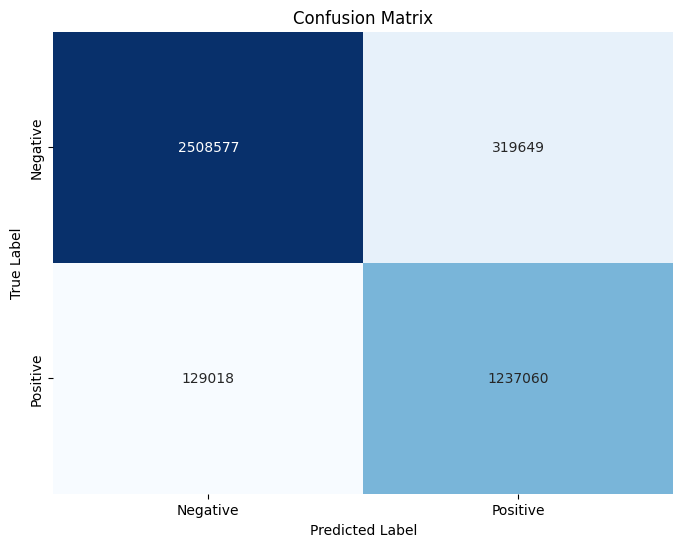

Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.89      0.92   2828226
    Positive       0.79      0.91      0.85   1366078

    accuracy                           0.89   4194304
   macro avg       0.87      0.90      0.88   4194304
weighted avg       0.90      0.89      0.89   4194304



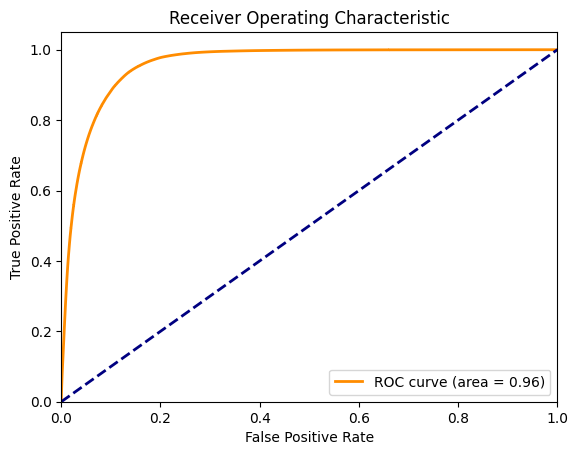

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

y_true = []
y_pred = []

# Evaluate the model on a predefined number of images
num_images_to_evaluate = 100  # Set this to the number of images you want to evaluate
count = 0

for X, y in image_label_generator(image_label_pairs):
    y_true.extend(y.flatten())
    y_pred.extend(model.predict(X).flatten())
    count += len(y)  # Assuming y is a batch of labels
    if count >= num_images_to_evaluate:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred > 0.5)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred > 0.5, target_names=['Negative', 'Positive']))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

 1/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9127 - loss: 0.2172

 2/10 ━━━━━━━━━━━━━━━━━━━━ 5s 748ms/step - accuracy: 0.9156 - loss: 0.2118

 3/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9171 - loss: 0.2090   

 4/10 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9168 - loss: 0.2091

 5/10 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9167 - loss: 0.2088

 6/10 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9164 - loss: 0.2091

 7/10 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9155 - loss: 0.2099

 8/10 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9144 - loss: 0.2112

 9/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9131 - loss: 0.2129

10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9110 - loss: 0.2157


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
(32, 128, 256, 1)


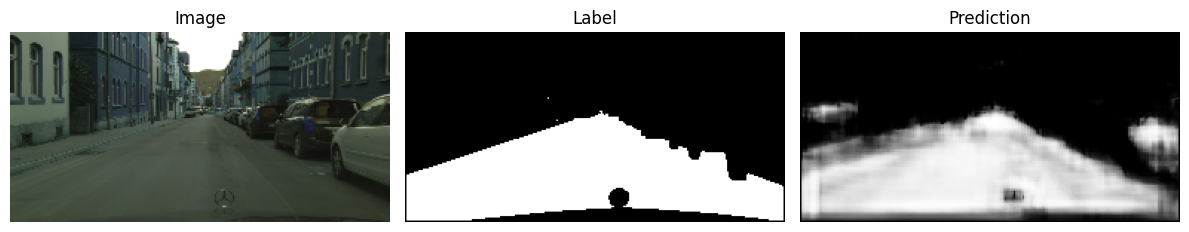

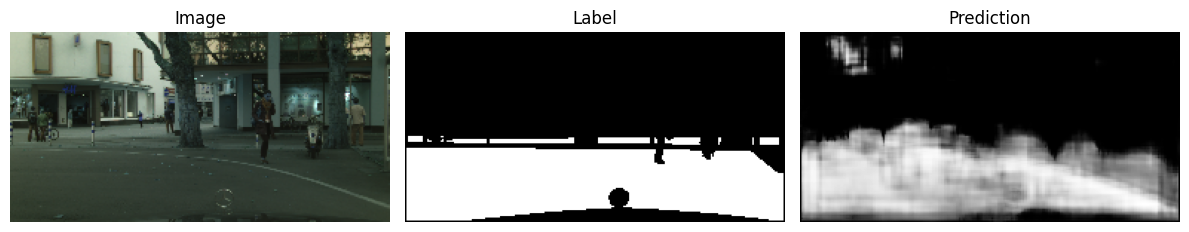

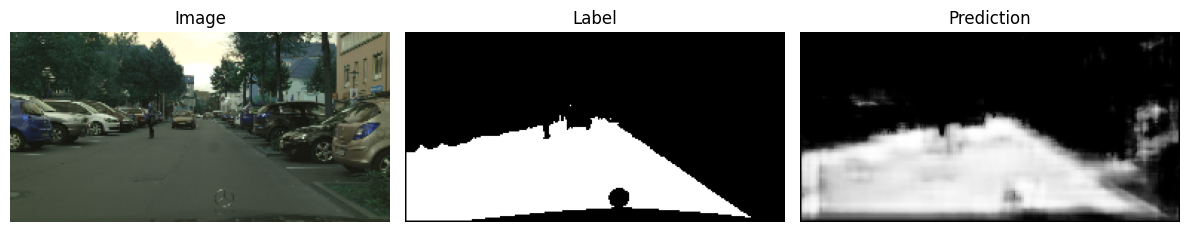

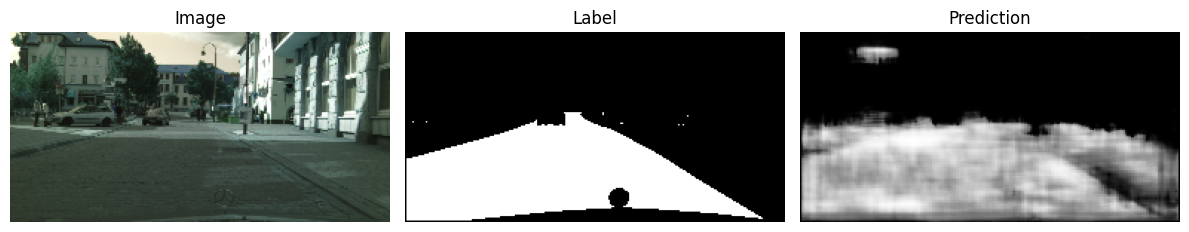

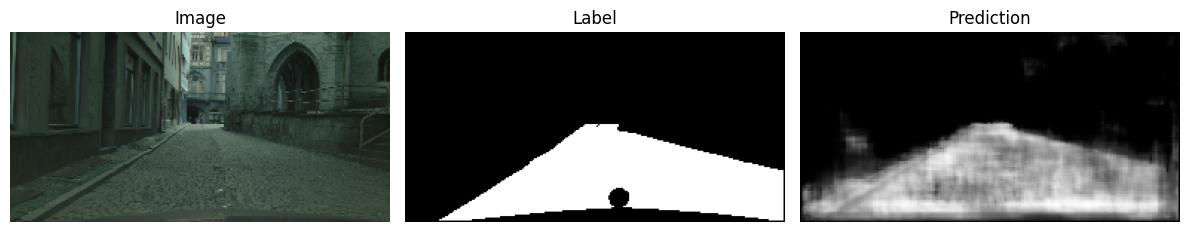

In [ ]:
# evaluate the model
model.evaluate(val_generator, steps=10)

# Predict on a batch of images
X_batch, y_batch = next(val_generator)
y_pred = model.predict(X_batch)
print(y_pred.shape)  # (32, 128, 256, 1)

# Visualize the predictions with the original images and labels in the same plot row by row
import matplotlib.pyplot as plt
for i in range(5):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X_batch[i])
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(y_batch[i].squeeze(), cmap="gray")
    axes[1].set_title("Label")
    axes[1].axis("off")
    axes[2].imshow(y_pred[i].squeeze(), cmap="gray")
    axes[2].set_title("Prediction")
    axes[2].axis("off")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


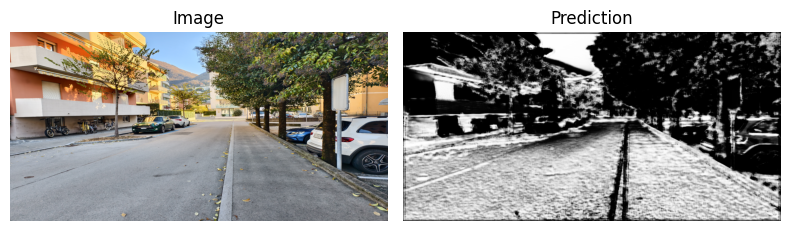

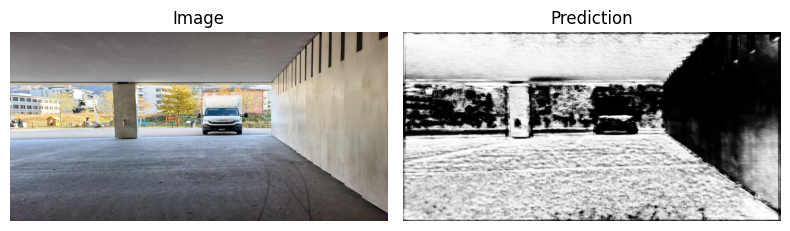

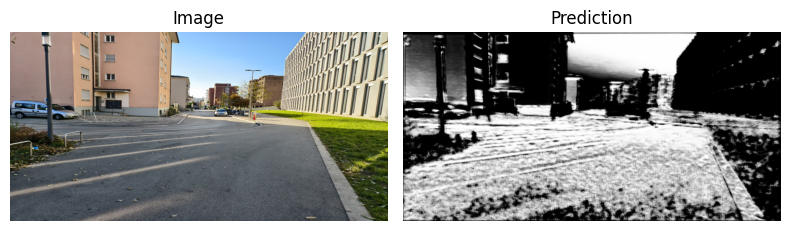

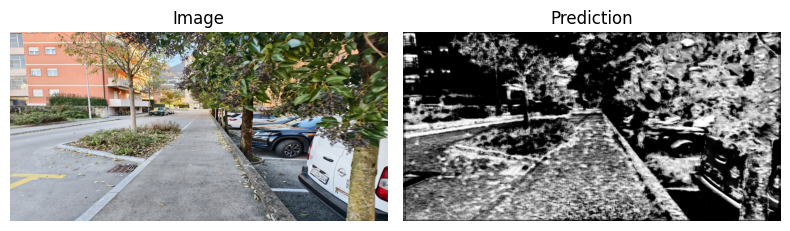

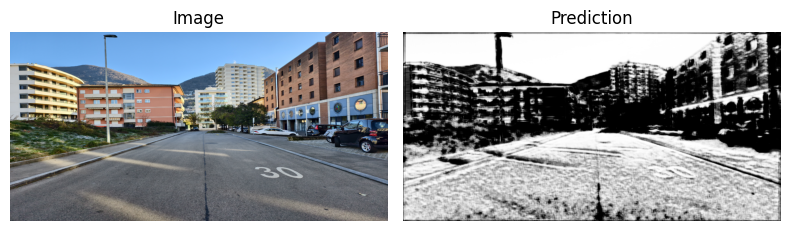

In [21]:
import os
import cv2
import numpy as np
from tensorflow.keras import models
import matplotlib.pyplot as plt

# Load and preprocess the images
personal_images = []

image_folder = os.path.join('..', 'data', 'personal_images')
for image_name in os.listdir(image_folder)[:5]:
    if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(image_folder, image_name)
        original = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Convert the original image to RGB
        image = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Resize the image
        image = cv2.resize(image, (2048, 1024))
        
        # Append the processed image to the list
        personal_images.append(image)

personal_images = np.array(personal_images)

# Predict on the images
predictions = model.predict(personal_images)

# Visualize the predictions
for i in range(len(personal_images)):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(personal_images[i])
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(predictions[i].squeeze(), cmap="gray")
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()